# Setup

In [1]:
# Once per boot
!ipfw pipe config 1 delay 0
!ipfw pipe config 2 delay 0
!ipfw add 1 pipe 1 tcp from any 10141 to any via lo0
!ipfw add 2 pipe 2 tcp from any to any 1011 via lo0
!ifconfig lo0 mtu 1500

00001 pipe 1 tcp from any 10141 to any via lo0
00002 pipe 2 tcp from any to any dst-port 1011 via lo0


In [2]:
# Extract and build the benchmark
!rm -f ipc/ipc-static
!rm -f ipc/ipc-dynamic
!rm -f ipc/ipc-no-nagle
!make -C ipc
!sysctl kern.ipc.maxsockbuf=33554432

cc -DWITH_PMC -Wall -o ipc-static -DPROGNAME=\"ipc-static\" ipc.c -static  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-dynamic -DPROGNAME=\"ipc-dynamic\" ipc.c -dynamic  -lpmc -lpthread
cc -DWITH_PMC -Wall -o ipc-no-nagle -DPROGNAME=\"ipc-no-nagle\" ipc-no-nagle.c -static  -lpmc -lpthread
kern.ipc.maxsockbuf: 2097152 -> 33554432


In [2]:
import itertools
import re

def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def flatten(lst):
    return list(itertools.chain.from_iterable(lst))

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

def genfilename(exe, mode, ipc, runs, flags, suffix="", extension = "png"):
    return "{}_{}_{}_runs_{}_{}{}.{}".format(re.sub(r'[/-]', r'_', exe), mode, ipc, runs, re.sub(r'\s*-', r'', flags), suffix, extension)

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

In [3]:
import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
#import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
from cStringIO import StringIO
import sys

def label_points(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

def graph(xs, ys, num_trials = 0, save = False, save_name = None, ticks = None, texty = 100, ylog = False, xlog = False, title = None, xlabel = None, ylabel = None, label = '_nolegend_', axis = None):
    # plt.style.use('seaborn-whitegrid')
    xvalues = np.reshape(ys, (len(xs), num_trials))[:,:]
    #xvalues = np.reshape(ys, (len(xs)/num_trials, num_trials))[:,:]
    df = pd.DataFrame(xvalues, index=xs)
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]
    if axis is not None:
        ax = df.median(1).plot(yerr=error_bars_values, title=title, ax=axis, label = label)
    else:
        fig = plt.figure(figsize=(18,6))
        ax = df.median(1).plot(yerr=error_bars_values, title=title, label = label)

    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.set_label(label)
    if title:
        ax.set_title(title)
    if ylog:
        ax.set_yscale('log')
    if xlog:
        ax.set_xscale('log')
    if ticks is None:
        ax.set_xticks(df.index)
        ax.set_xticklabels(xs, rotation=45)
    plt.grid('on', axis='x' )
    plt.grid('on', axis='y' )
    plt.legend()
    if save_name is not None:
        ax.get_figure().savefig("{}".format(save_name))
    return ax

def benchmark(flags, repeat, exe, mode, ipc, buf_sizes, tot_sizes, default_buffer = False, dtrace_info = None, bench_name = "", pmc = None, quiet = False, purge_cache = False):
    runs = range(1, repeat + 1)
    outputs = []
    if not quiet:
        print("\t ==> Running {}".format(exe))
        print("\t\t ==> {} across {}".format(ipc, mode))
    is_dtrace = (dtrace_info != None)
    if is_dtrace and not quiet:
        print("\t\t ==> Running in DTrace mode")
    dtrace_thread = None
    verbose = "-v" in flags
    qmode = "-q" in flags
    pmc_enabled = pmc is not None
    dtrace_quite_mode = dtrace_info['quiet'] if dtrace_info is not None and 'quiet' in dtrace_info else False

    for buffer_size in buf_sizes:
        for tot_size in tot_sizes:
            if default_buffer:
                cmd = "{} {} -i {} {}".format(exe, flags, ipc, mode)
            else:
                cmd = "{} {} -i {} -b {} -t {} {}".format(exe, flags, ipc, buffer_size, tot_size, mode)

            discard = !{cmd} # Discard first benchmark run which may be biased
            if is_dtrace:
                dtraceSleep = dtrace_info['sleep'] if 'sleep' in dtrace_info else 1
                walkFunc = dtrace_info['agg_fn'] if 'agg_fn' in dtrace_info else None
                outFn = dtrace_info['out_fn'] if 'out_fn' in dtrace_info else None
                # Create a seperate thread to run the DTrace instrumentation
                if dtrace_quite_mode:
                    old_stdout = sys.stdout
                    sys.stdout = mystdout = StringIO()
                dtrace_thread = DTraceConsumerThread(dtrace_info['script'],
                                                        chew_func=lambda v: None,
                                                        chewrec_func=lambda v: None,
                                                        walk_func=None,
                                                        out_func=outFn,
                                                        sleep=dtraceSleep)
                # Start the DTrace instrumentation
                dtrace_thread.start()

            results = []
            for i in runs:
                out = !{cmd}
                if purge_cache:
                    purge_cmd = "sysctl net.inet.tcp.hostcache.purgenow=1"
                    !{purge_cmd}
                parsed = parse(out)
                results.append(parsed)

            if is_dtrace and dtrace_thread != None:
                # The benchmark has completed - stop the DTrace instrumentation
                dtrace_thread.stop()
                dtrace_thread.join()
                dtrace_thread.consumer.__del__() # Memory leak workaround

            times = [float(item['time']) for item in results] if verbose else None
            avg_time = sum(times) / len(runs) if verbose else None

            if not qmode:
                speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see ipc.c)
            else:
                speeds = []
            avg_speed = sum(speeds) / len(runs)
            if not quiet:
                print("\t\t\t{0:2} bytes {1:2} bytes: {2:.2f} KBytes/sec".format(buffer_size, tot_size, avg_speed))
            res = {'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'tot_sz':tot_size, 'speeds': speeds, 'times': times}
            if pmc_enabled:
                pmc_data = gather_pmc_vals({}, results, pmc)

                avgs = {}
                for key,val in pmc_data.iteritems():
                    avg_key = "avg_" + key
                    avgs[avg_key] = sum(val) / len(runs)

                pmc_data['pmctype'] = results[0]["pmctype"]
                # Merge dictionaries
                pmc_data = merge_two_dicts(avgs, pmc_data)
                res = merge_two_dicts(res, pmc_data)
            outputs.append(res)
            if dtrace_quite_mode:
                sys.stdout = old_stdout
    return outputs

def highlight(axis, texty = 100):
    axis.axvspan(0, 8192, alpha=0.15, color='r')
    axis.axvspan(8193, 32768, alpha=0.15, color='g')
    axis.axvspan(32769, 65536, alpha=0.15, color='m')
    axis.axvspan(65537, 131072, alpha=0.15, color='c')
    axis.axvspan(131073, 262144, alpha=0.15, color='y')
    axis.text(3500, texty, "4K Page Size")
    axis.text(12000, texty, "16K PIPE_SIZE")
    axis.text(30000, texty, "32K L1")
    axis.text(90000, texty, "32x4K TLB entries")
    axis.text(250000, texty, "256K L2")

In [4]:
D_transitions_snd2rcv = """
fbt::tcp_state_change:entry
/args[0]->t_inpcb->inp_inc.inc_ie.ie_lport == htons(10141)/
{
    printf("{\\"timestamp\\": %u, \\"local_port\\": %u, \\"foreign_port\\": %u, \\"previous_tcp_state\\": \\"%s\\", \\"tcp_state\\": \\"%s\\"}", 
    walltimestamp,
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
    tcp_state_string[args[0]->t_state],
    tcp_state_string[args[1]]);

    stack();
}
"""

D_transitions_rcv2snd = """
fbt::tcp_state_change:entry
/args[0]->t_inpcb->inp_inc.inc_ie.ie_fport == htons(10141)/
{
    printf("{\\"timestamp\\": %u, \\"local_port\\": %u, \\"foreign_port\\": %u, \\"previous_tcp_state\\": \\"%s\\", \\"tcp_state\\": \\"%s\\"}", 
    walltimestamp,
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
    ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
    tcp_state_string[args[0]->t_state],
    tcp_state_string[args[1]]);

    stack();
}
"""

# For probe effect
D_rcv_tcp_in = """
/* From receiver to sender */
fbt::tcp_do_segment:entry
/args[1]->th_dport == htons(10141)
    || args[1]->th_sport == htons(10141)/
{
        ((unsigned int)args[1]->th_seq);
        ((unsigned int)args[1]->th_ack);
        (args[3]->t_state);
}

"""

D_snd_tcp_in = """
/* From sender to receiver */
#pragma D option bufsize=3M
#pragma D option bufresize=manual

fbt::tcp_do_segment:entry
/args[1]->th_sport == htons(10141)/
{
        /*trace((unsigned int)args[1]->th_seq);
        trace((unsigned int)args[1]->th_ack);*/
        trace(tcp_state_string[args[3]->t_state]);
        printf("[%s", (args[1])->th_flags & TH_FIN ? "FIN|" : "");
        printf("%s", (args[1])->th_flags & TH_SYN ? "SYN|" : "");
        printf("%s", (args[1])->th_flags & TH_RST ? "RST|" : "");
        printf("%s", (args[1])->th_flags & TH_PUSH ? "PUSH|" : "");
        printf("%s", (args[1])->th_flags & TH_ACK ? "ACK|" : "");
        printf("%s", (args[1])->th_flags & TH_URG ? "URG|" : "");
        printf("%s", (args[1])->th_flags & TH_ECE ? "ECE|" : "");
        printf("%s]", (args[1])->th_flags & TH_CWR ? "CWR" : "");
}
"""

D_state_change = """
fbt::tcp_state_change:entry
/args[0]->t_inpcb->inp_inc.inc_ie.ie_lport == htons(10141)
        || args[0]->t_inpcb->inp_inc.inc_ie.ie_fport == htons(10141)/
{
        printf("{ \\"time\\":\\"%u\\", \\"local_port\\":\\"%u\\", \\"foreign_port\\":\\"%u\\", \\"previous_tcp_state\\":\\"%s\\", \\"tcp_state\\":\\"%s\\" }",
        walltimestamp,
        ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport),
        ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport),
        tcp_state_string[args[0]->t_state],
        tcp_state_string[args[1]]);

        stack();
}
/*
fbt::syncache_add:entry
/args[3]->inp_inc.inc_ie.ie_lport == htons(10141)
        || args[3]->inp_inc.inc_ie.ie_fport == htons(10141)/
{
        printf("{ \\"probefunc\\":\\"%s\\", \\"local_port\\":\\"%u\\", \\"foreign_port\\":\\"%u\\", \\"flags\\":\\"%d\\" }",
        probefunc,
        ntohs(args[3]->inp_inc.inc_ie.ie_lport),
        ntohs(args[3]->inp_inc.inc_ie.ie_fport),
        (args[2])->th_flags);

        stack();
}

fbt::syncache_expand:entry
/args[0]->inc_ie.ie_lport == htons(10141)
        || args[0]->inc_ie.ie_fport == htons(10141)/
{
        printf("{ \\"probefunc\\":\\"%s\\", \\"local_port\\":\\"%u\\", \\"foreign_port\\":\\"%u\\", \\"flags\\":\\"%d\\" }",
        probefunc,
        ntohs(args[0]->inc_ie.ie_lport),
        ntohs(args[0]->inc_ie.ie_fport),
        (args[2])->th_flags);

        stack();
}
*/
"""

In [5]:
import pygraphviz as pgv
from IPython.display import Image

# TCP related utils
def print_ascii_state_machine(out):
    for key,elem in out.iteritems():
        for raw_value in elem:
            try:
                value = json.loads(raw_value)
                # JSON formatted string
                if value['previous_tcp_state'] is not None and value['tcp_state'] is not None:
                    print("State transition {} ({}) -> {} ({})".format(value['previous_tcp_state'],
                                                                       value['local_port'], value['tcp_state'],
                                                                       value['foreign_port']))
                else:
                    print("String malformatted missing previous_tcp_state of tcp_state fields")
            except ValueError as e:
                # Raw string - manually post-process
                print("Preceeding stack frame {}".format(raw_value.split('\n')[1]))
        print("\n")

def draw_state_machine(data, latency):
    # Create state machine
    g = pgv.AGraph(
        label="TCP state machine ({} ms latency)".format(latency), strict=False, directed=True)

    # Add edges
    edges_to_add = []
    for raw_value in data[latency]:
        arch = ""
        try:
            value = json.loads(raw_value)
            if 'local_port' in value:
                arch = "server" if value['local_port'] == '10141' else "client"
            # JSON formatted string
            if 'probefunc' in value:
                print(value['probefunc'])
                edges_to_add.append(value['probefunc'])
                edges_to_add.append(value['probefunc'])
                edges_to_add.append(arch)
            elif value['previous_tcp_state'] is not None and value['tcp_state'] is not None:
                edges_to_add.append(value['previous_tcp_state'])
                edges_to_add.append(value['tcp_state'])
                edges_to_add.append(arch)
            else:
                print("String malformatted missing previous_tcp_state of tcp_state fields")
        except ValueError as e:
            # Raw string - manually post-process
            # print("Preceeding stack frame {}".format(raw_value.split('\n')[1]))
            # print(raw_value.split('\n'))
            syscall = raw_value.split('\n')[1].split('`')[1].split('+')[0]
            label = "{}: {}".format(edges_to_add[2], syscall)
            g.add_edge(edges_to_add[0], edges_to_add[1], label=label, color='green')
            edges_to_add = []

    closed_node = g.get_node("state-closed")
    closed_node.attr['shape']='box'
    closed_node.attr['color']='blue'

    # Draw the state machine
    return g

In [6]:
import itertools
def process_segments(filename, extra = [], port = "source", single_ack = False, normalize = False):
    ENTRIES = []
    attrs = ["Time", "Seq", "Ack"] + extra
    text_file = open(filename, "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split() for l in lines if "tcp_do_segment" in l]

    # Aggregate info into list
    # Order is important
    for e in lines:
        entry = {}
        for kv in e:
            split = kv.split(':')
            if len(split) == 2:
                entry[split[0]] = split[1]
        ENTRIES.append(entry);

    ret = {}
    for a in attrs:
        ret[a] = []
    for e in ENTRIES:
        if int(e[port]) == 10141:
            for a in attrs:
                #if a == "Time":
                #    ret[a].append(float(e[a]) / 1000000000)
                #else:
                #    ret[a].append(int(e[a]))
                ret[a].append(int(e[a]))
    if single_ack:
        curr_time = None
        tms = []
        aks = []
        for t, a in itertools.izip(ret["Time"], ret["Ack"]):
            if curr_time is None or t != curr_time:
                aks.append(a)
                tms.append(t)
                curr_time = t
        ret["SingleAckTime"] = tms
        ret["SingleAcks"] = aks
    if normalize:
        times_ = ret["Time"]
        ret["Time"] = [float(t - times_[0]) / 1000000000 for t in times_]
    return ret

In [7]:
def time_bw_data(filename, time_diffs = 0.001):
    TIMES = []
    ENTRIES = []
    text_file = open("{}.log".format(filename), "r")
    lines = text_file.read().split("\n")
    lines = [l.strip().split() for l in lines if "tcp_do_segment" in l]

    # Aggregate info into list
    # Order is important
    for e in lines:
        entry = {}
        if e == '#':
            ENTRIES.append(e)
        for kv in e:
            split = kv.split(':')
            if len(split) == 2:
                entry[split[0]] = split[1]
        ENTRIES.append(entry)

    final_len = 0
    TIME_SPLIT = 150
    cur_time = float(ENTRIES[0]["Time"])
    cur_seq = float(ENTRIES[0]["Seq"])
    bws = []
    unit_ctr = 0
    for e in ENTRIES:
        diff = ((float(e["Time"]) - cur_time) / 1000000000)
        if diff > time_diffs and int(e["source"]) == 10141:
            bws.append(e)
            cur_time = float(e["Time"])

    bws = zip(bws[::2], bws[1::2])

    # TODO: make sure sequence numbers are sorted in "bws"
    tps = []
    for e in bws:
        tp = (float(e[1]["Seq"]) - float(e[0]["Seq"])) / (float(e[1]["Time"]) - float(e[0]["Time"]))
        tps.append(max(tp, 0))

    times = [list(b)[1]["Time"] for b in bws]
    times = [(float(t) - float(times[0]))/1000000000 for t in times]
    return (times, tps)

In [33]:
def plot_windows(latency):
    filename = "combined_{}_1.log".format(latency)
    filename_s = "combined_{}_1_-s.log".format(latency)
    ret_rcv = process_segments(filename, port = "dest", extra = ["cwnd", "wnd", "ssthresh"], normalize = True)
    ret_snd = process_segments(filename, port = "source", extra = ["cwnd", "wnd", "ssthresh"], normalize = True)
    times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
    times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
    ret_rcv_s = process_segments(filename_s, port = "dest", extra = ["cwnd", "wnd", "ssthresh"], normalize = True)
    ret_snd_s = process_segments(filename_s, port = "source", extra = ["cwnd", "wnd", "ssthresh"], normalize = True)
    times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
    times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])
    fig = plt.figure(figsize=(15, 8)) #figsize=(10, 10), dpi=80
    plt.ticklabel_format(useOffset=False)
    ax = plt.gca()
    wnd, cwnd, ssthresh = (ret_rcv["wnd"], ret_rcv["cwnd"], ret_rcv["ssthresh"])
    ax.plot(times_acks, cwnd, label = "cwnd")
    ax.plot(times_acks, wnd, label = "wnd")
    ax.plot(times_acks, ssthresh, label = "sstresh")
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    ax.set_title("Receive Wnd/Congestion Wnd/Slow-Start Threshold Across Lifetime of TCP Connection with Auto-Sizing Buffers ({}ms Latency)".format(latency))
    ax.set_ylabel("Window Buffer Size (Bytes)")
    ax.set_xlabel("Time Into Connection (s)")
    fig = plt.figure(figsize=(15, 8)) #figsize=(10, 10), dpi=80
    plt.ticklabel_format(useOffset=False)
    ax = plt.gca()
    wnd_s, cwnd_s, ssthresh_s = (ret_rcv_s["wnd"], ret_rcv_s["cwnd"], ret_rcv_s["ssthresh"])
    ax.plot(times_acks_s, cwnd_s, label = "cwnd")
    ax.plot(times_acks_s, wnd_s, label = "wnd")
    ax.plot(times_acks_s, ssthresh_s, label = "sstresh")
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    ax.set_title("Receive Wnd/Congestion Wnd/Slow-Start Threshold Across Lifetime of TCP Connection with Manual Buffer Sizing ({}ms Latency)".format(latency))
    ax.set_ylabel("Window Buffer Size (Bytes)")
    ax.set_xlabel("Time Into Connection (s)")

In [8]:
def calc_bw(data):
    sortedKeys = data.keys()
    sortedKeys.sort()
    for buf in sortedKeys:
        ns = float(data[buf]['vtime']) / float(1e9)
        print(str((buf / 1024) / ns) + " KB/sec.")

# Callbacks invoked to process the aggregation
def test_agg(a, b, c, d):
    print("From DTrace: {} | {} | {} | val: {}".format(a,b,c,d))
def test_out(val):
    print("From DTrace: val: {}".format(val))

def simple_agg(a, b, c, d):
    values.append(d)
def simple_out(val):
    values.append(val)

def acc_agg(a, b, c, d):
    if c[0] not in values:
        values[c[0]] = [d]
    else:
        values[c[0]].append(d)

def map_agg(a, b, c, d):
    if len(c):
        values[c[0]] = d

def pair_agg(a, b, c, d):
    values.append((c, d))

def quantized_agg(a, b, c, d):
    dist = d
    filtered = [tup if tup[0][0] >= -2 and tup[0][0] <= BUFFER_SIZES[-1] else None for tup in dist]
    filtered = [x for x in filtered if x is not None ]
    values[c[0]] = filtered

def dummy_agg(a, b, c, d):
    pass

print("Set up completed")

Set up completed


# State Machine

In [20]:
# States from state_change
# Headers from tcp_do_segment
# Syscalls from state_change stack (if headers not available)

MODE="2thread"
IPC="tcp"
FLAGS=""
RUNS=1
DRUNS=1
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]
BUF_SIZE=[131072]
LATENCIES=range(0, 45, 5) # 0-40ms

out = {}
values = []
for lat in LATENCIES:
    print("Latency: {}".format(lat))
    # Run benchmark with DTrace
    !ipfw pipe config 1 delay {str(lat)}
    !ipfw pipe config 2 delay {str(lat)}
    benchmark(FLAGS, 1, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, default_buffer = True, dtrace_info = {'out_fn':simple_out, 'script':D_state_change},
                 purge_cache = False)
    time.sleep(1)
    out[lat] = values
    values = []
    print("Finished with latency")
pd.to_pickle(out, "pkls/state_changes_with_flags.pkl")

Latency: 0
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 28235.34 KBytes/sec
Finished with latency
Latency: 5
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 28164.70 KBytes/sec
Finished with latency
Latency: 10
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 11763.14 KBytes/sec
Finished with latency
Latency: 15
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 12047.17 KBytes/sec
Finished with latency
Latency: 20
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 5976.54 KBytes/sec
Finished with latency
Latency: 25
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
			131072 bytes 16777216 bytes: 6006.05 KBytes/sec


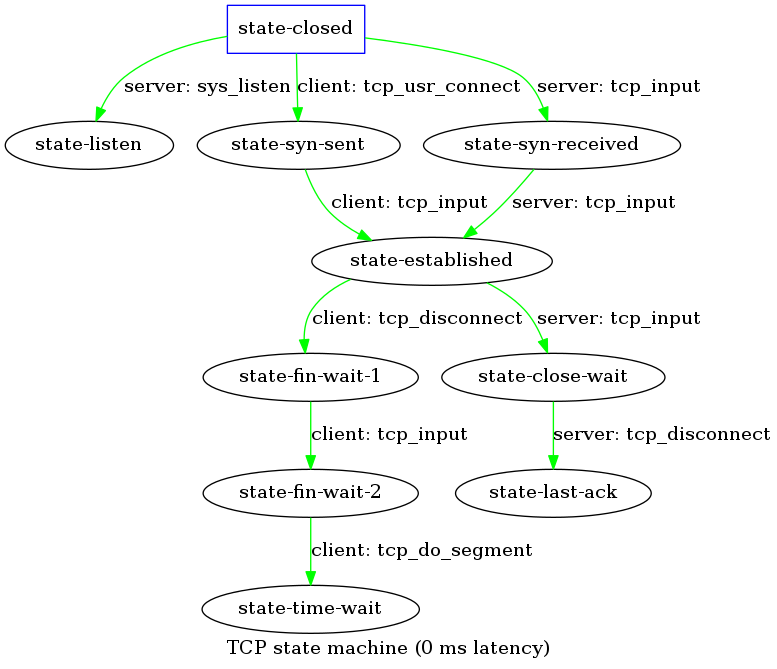

In [26]:
out = pd.read_pickle("pkls/state_changes.pkl")

g = draw_state_machine(out, 0)
Image(g.draw(format='png', prog='dot'))

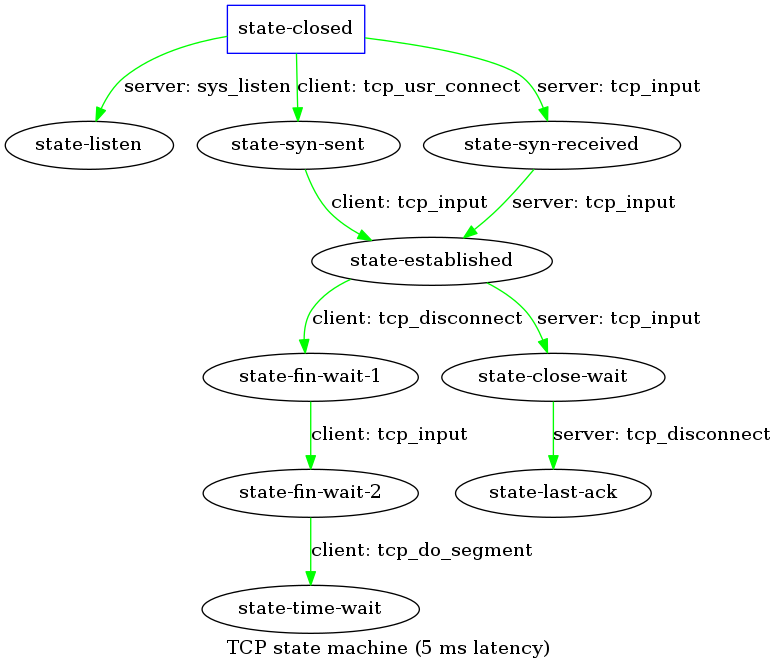

In [27]:
g = draw_state_machine(out, 5)
Image(g.draw(format='png', prog='dot'))

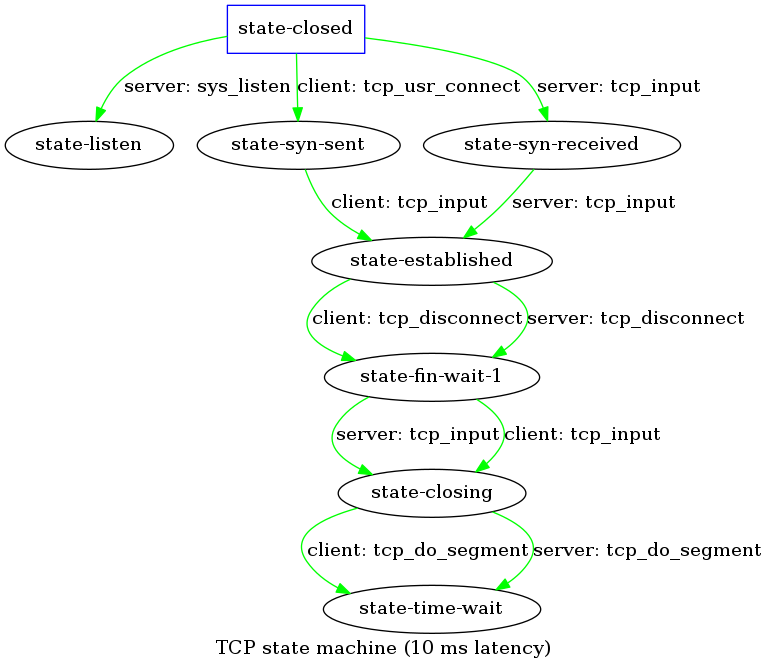

In [28]:
g = draw_state_machine(out, 10)
Image(g.draw(format='png', prog='dot'))

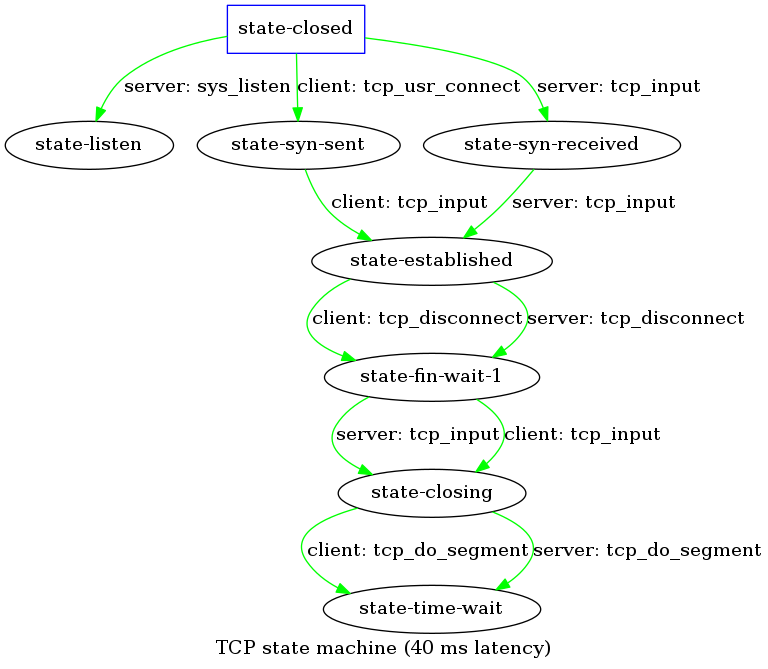

In [29]:
g = draw_state_machine(out, 40)
Image(g.draw(format='png', prog='dot'))

#  Bandwidth vs. Latency

# Purge Cache Performance

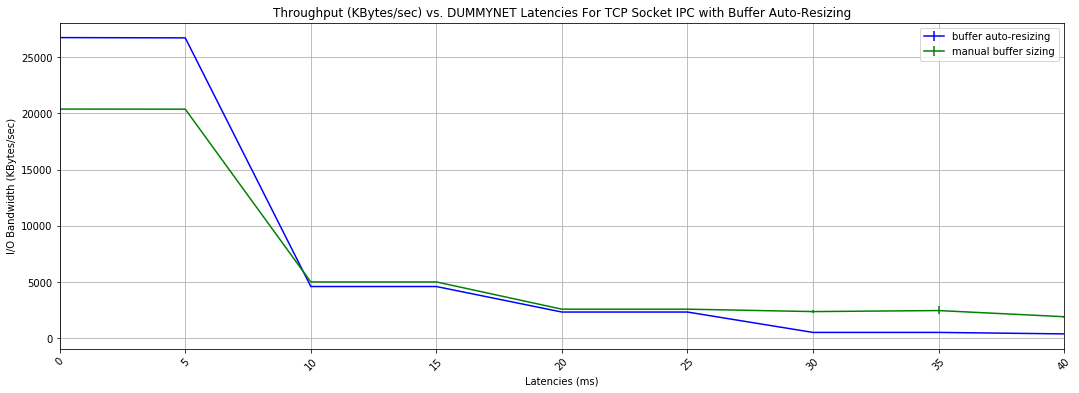

In [39]:
MODE="2thread"
IPC="tcp"
RUNS=12
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]
BUF_SIZE=[1048576]
LATENCIES=range(0, 45, 5) # 0-40ms

#ret = []
#FLAGS=""
#for lat in LATENCIES:
#    # Run benchmark with DTrace
#    !ipfw pipe config 1 delay {str(lat)}
#    !ipfw pipe config 2 delay {str(lat)}
#    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True)[0])
#pd.to_pickle(ret, "pkls/latency_vs_bandwidth_purge.pkl")

ret = pd.read_pickle("pkls/latency_vs_bandwidth_purge.pkl")
p = graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
         xlabel='Latencies (ms)', ylabel='I/O Bandwidth (KBytes/sec)',
          label="buffer auto-resizing", title = "Throughput (KBytes/sec) vs. DUMMYNET Latencies For TCP Socket IPC with Buffer Auto-Resizing")

#ret = []
#FLAGS="-s"
#for lat in LATENCIES:
#    # Run benchmark with DTrace
#    !ipfw pipe config 1 delay {str(lat)}
#    !ipfw pipe config 2 delay {str(lat)}
#    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True)[0])
#pd.to_pickle(ret, "pkls/latency_vs_bandwidth_match_purge.pkl")

saveas = "latency_vs_bw_all"
ret = pd.read_pickle("pkls/latency_vs_bandwidth_match_purge.pkl")
graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
      axis = p, label="manual buffer sizing", save = True, save_name = saveas)

# Time vs. Bandwidth

## Average

In [14]:
RUNS = 8
LATENCY = 20 # 20ms RTT
BWS = []
TIMES = []
for i in range(1, RUNS + 1):
    FILENAME = "combined_{}_{}".format(LATENCY, i)
    (ts, bs) = time_bw_data(FILENAME)
    BWS.append(bs)
    TIMES.append(ts)

IOError: [Errno 2] No such file or directory: 'combined_20_2.log'

In [ ]:
min_length = len(BWS[0])
for b in BWS:
    min_length = min(min_length, len(b))
NEW_BWS = []
NEW_TIMES = []
for b in BWS:
    NEW_BWS.append(b[:min_length])
for t in TIMES:
    NEW_TIMES.append(t[:min_length])
TIMES = NEW_TIMES
BWS = NEW_BWS

AVGS = [sum(list(b)) / len(b) for b in zip(*BWS)]
plt.plot(TIMES[0], AVGS)

#graph(TIMES[0], AVGS, 1, label = "RTT = 10ms")

## Single Run

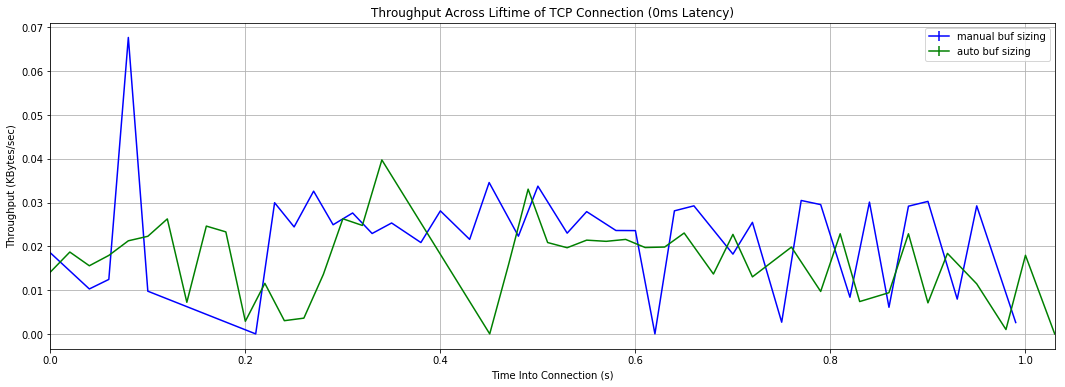

In [50]:
FILENAME="combined_0_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label="manual buf sizing", ticks = False)

FILENAME="combined_0_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label="auto buf sizing", ticks = False, axis = p, xlabel = "Time Into Connection (s)", ylabel = "Throughput (KBytes/sec)", title = "Throughput Across Liftime of TCP Connection (0ms Latency)")
#p.set_xticklabels([""] + ['%s' % float('%.3g' % i) for i in t2])

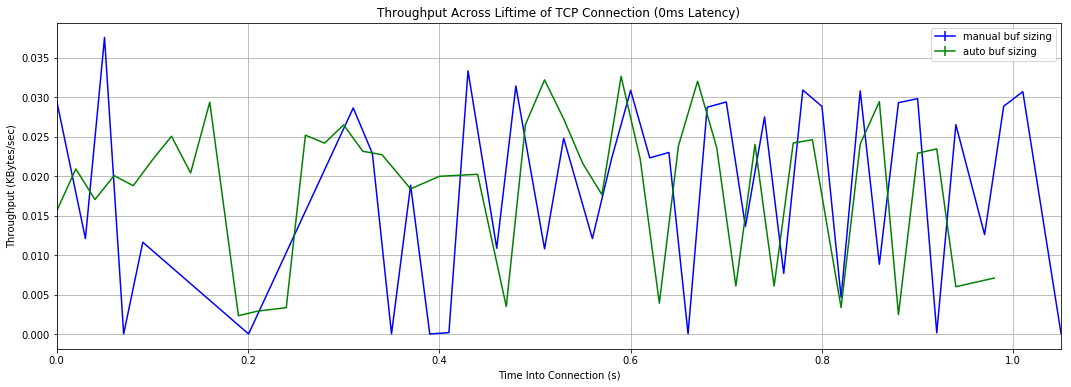

In [9]:
FILENAME="combined_5_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label="manual buf sizing", ticks = False)

FILENAME="combined_5_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label="auto buf sizing", ticks = False, axis = p, xlabel = "Time Into Connection (s)", ylabel = "Throughput (KBytes/sec)", title = "Throughput Across Liftime of TCP Connection (0ms Latency)")
#p.set_xticklabels([""] + ['%s' % float('%.3g' % i) for i in t2])

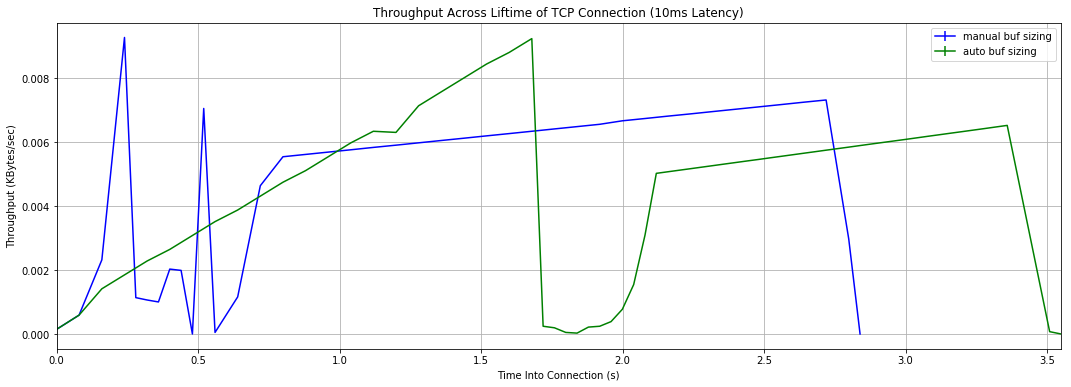

In [49]:
FILENAME="combined_10_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label="manual buf sizing", ticks = False)

FILENAME="combined_10_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label="auto buf sizing", ticks = False, axis = p, xlabel = "Time Into Connection (s)", ylabel = "Throughput (KBytes/sec)", title = "Throughput Across Liftime of TCP Connection (10ms Latency)")

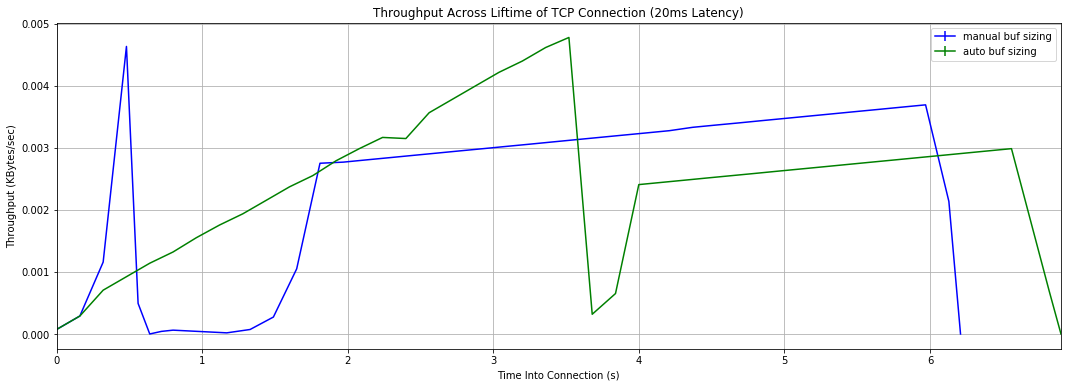

In [48]:
FILENAME="combined_20_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label="manual buf sizing", ticks = False)

FILENAME="combined_20_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label="auto buf sizing", ticks = False, axis = p, xlabel = "Time Into Connection (s)", ylabel = "Throughput (KBytes/sec)", title = "Throughput Across Liftime of TCP Connection (20ms Latency)")

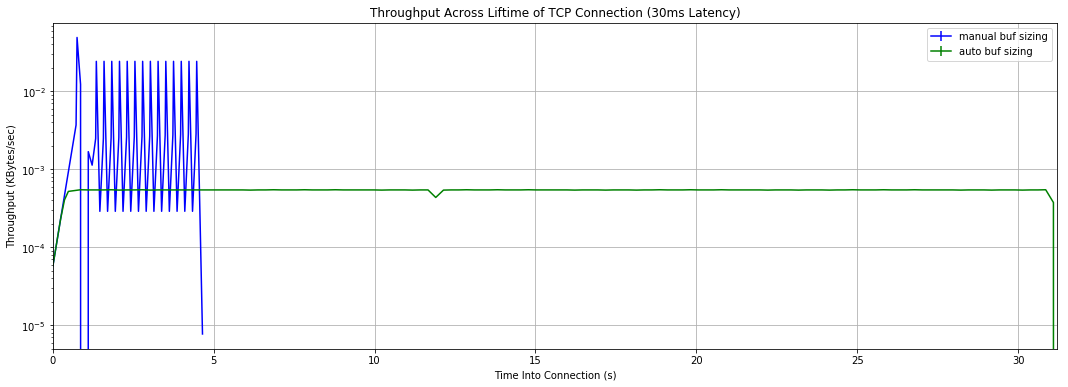

In [17]:
FILENAME="combined_30_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label="manual buf sizing", ticks = False, ylog = True)

FILENAME="combined_30_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label="auto buf sizing", ticks = False, ylog = True, axis = p, xlabel = "Time Into Connection (s)", ylabel = "Throughput (KBytes/sec)", title = "Throughput Across Liftime of TCP Connection (30ms Latency)")

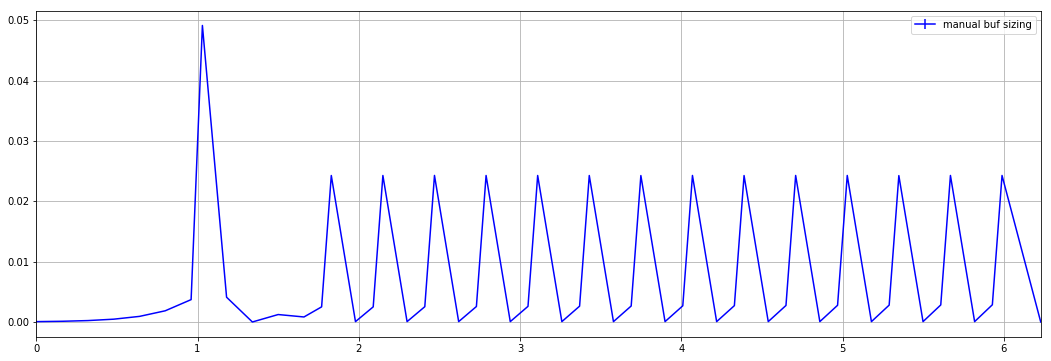

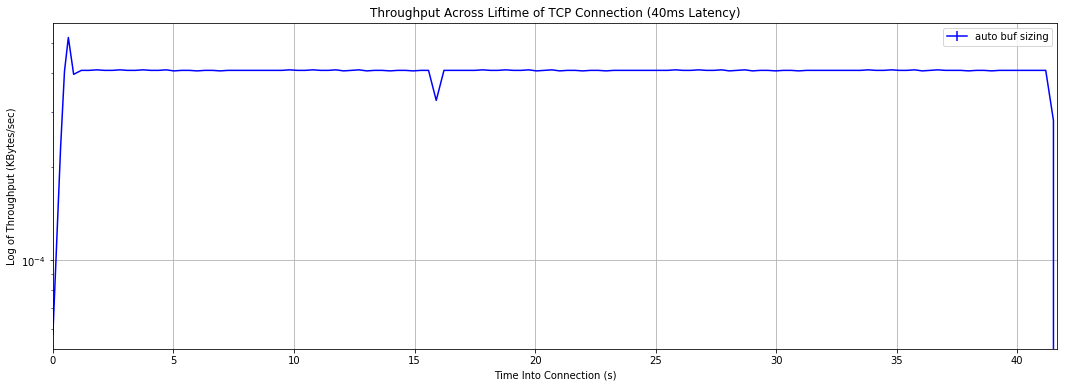

In [39]:
FILENAME="combined_40_1_-s"
(t2, b2) = time_bw_data(FILENAME, time_diffs = 0.001)
p = graph(t2, b2, 1, label="manual buf sizing", ticks = False, ylog = False)

FILENAME="combined_40_1"
(t1, b1) = time_bw_data(FILENAME)
p = graph(t1, b1, 1, label="auto buf sizing", ticks = False, ylog = True, axis = None, xlabel = "Time Into Connection (s)", ylabel = "Log of Throughput (KBytes/sec)", title = "Throughput Across Liftime of TCP Connection (40ms Latency)")

## 0ms

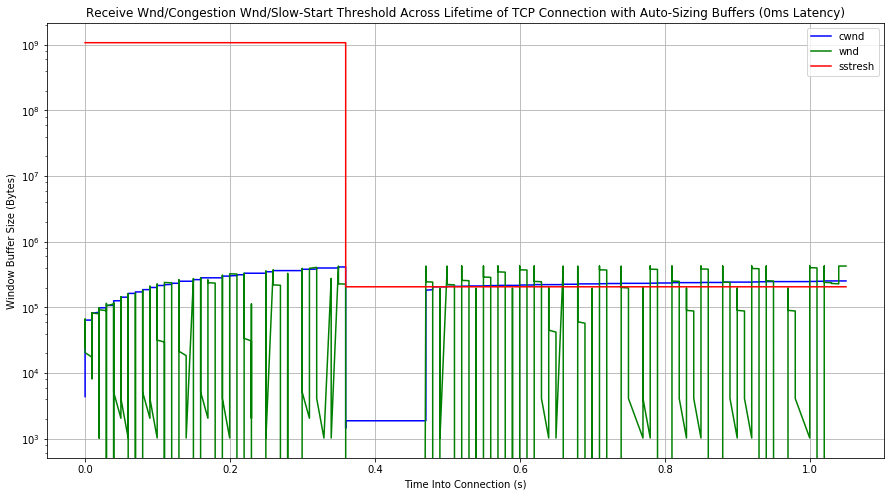

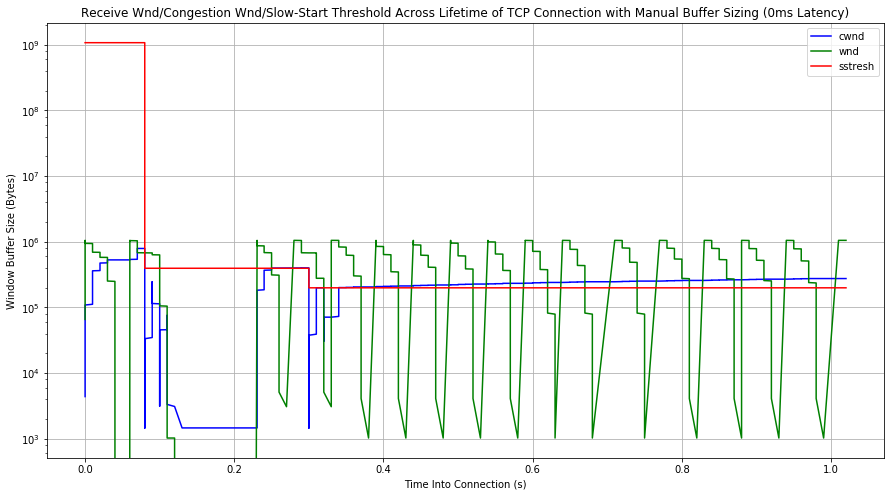

In [34]:
plot_windows(0)

## 5ms

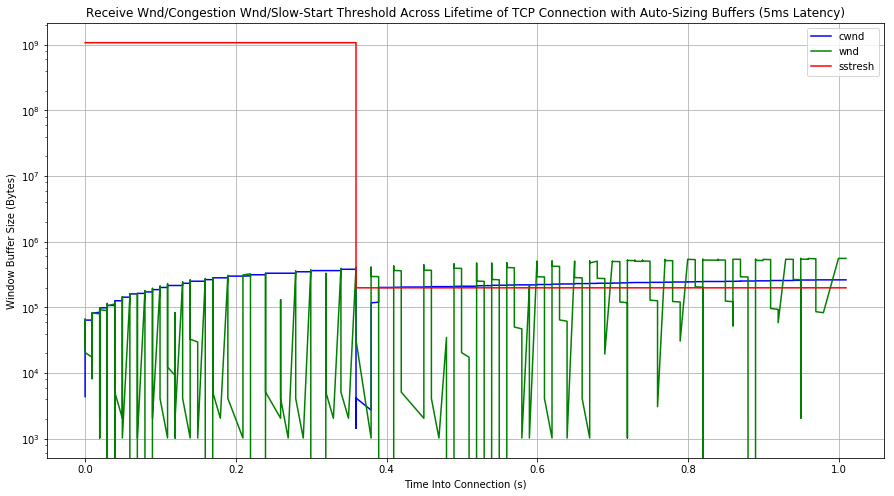

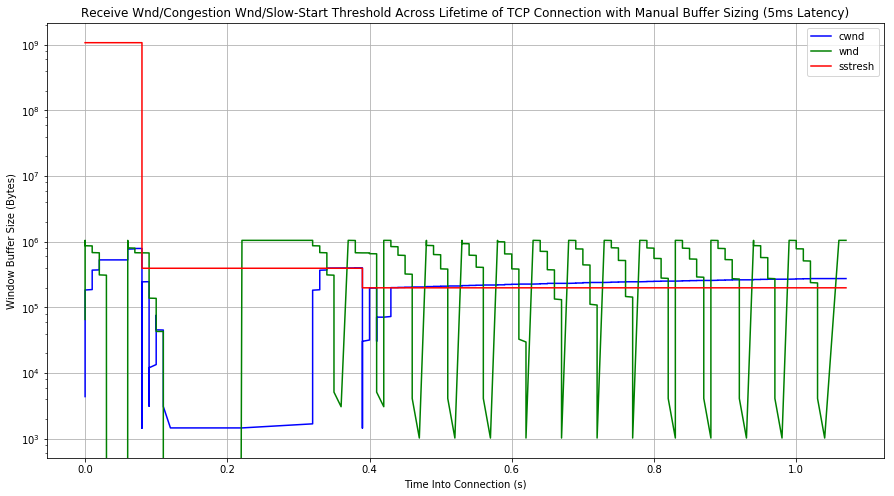

In [35]:
plot_windows(5)

## 10ms

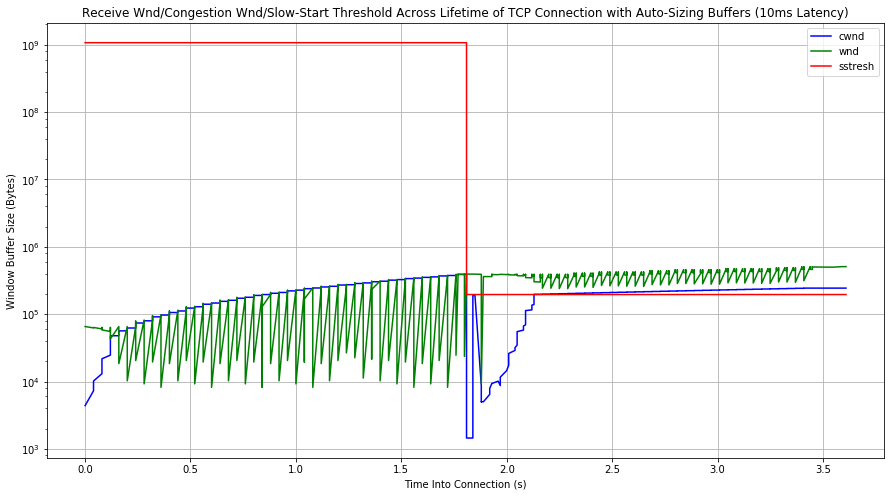

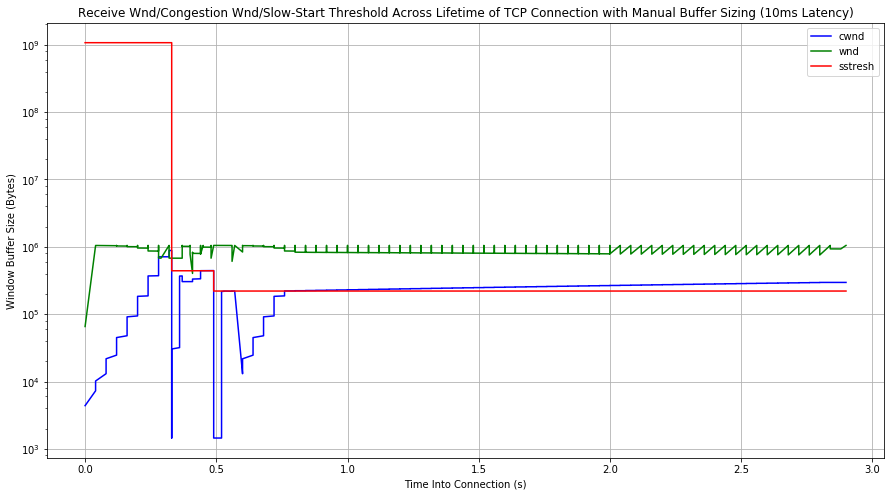

In [36]:
plot_windows(10)

## 20ms

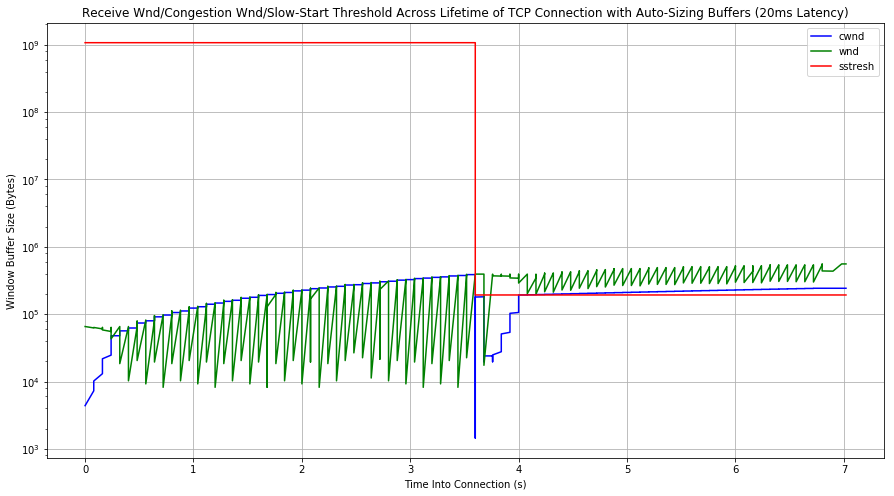

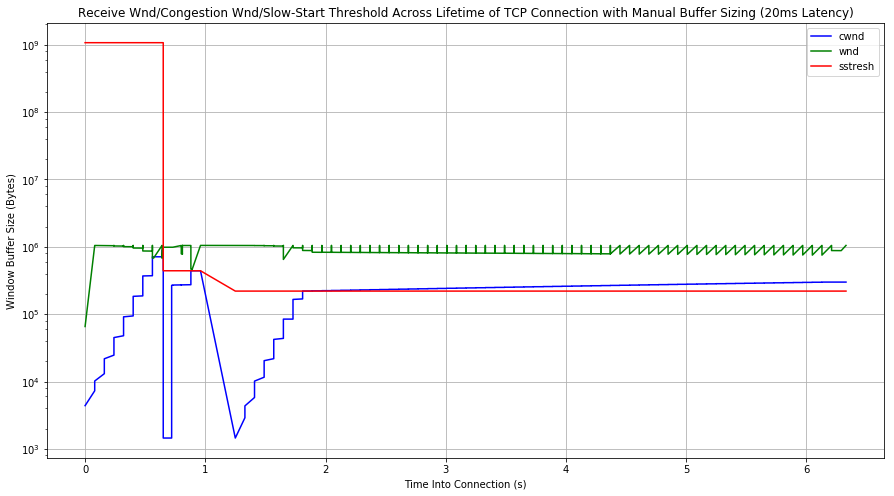

In [37]:
plot_windows(20)

## 30ms

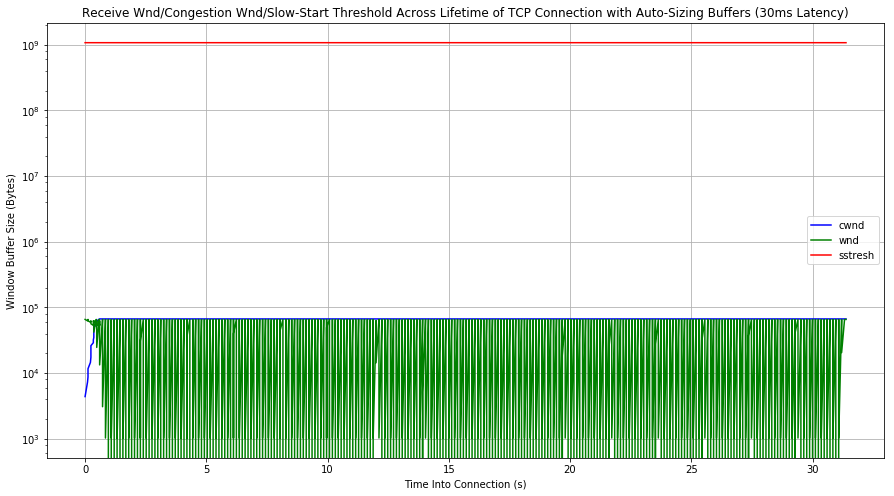

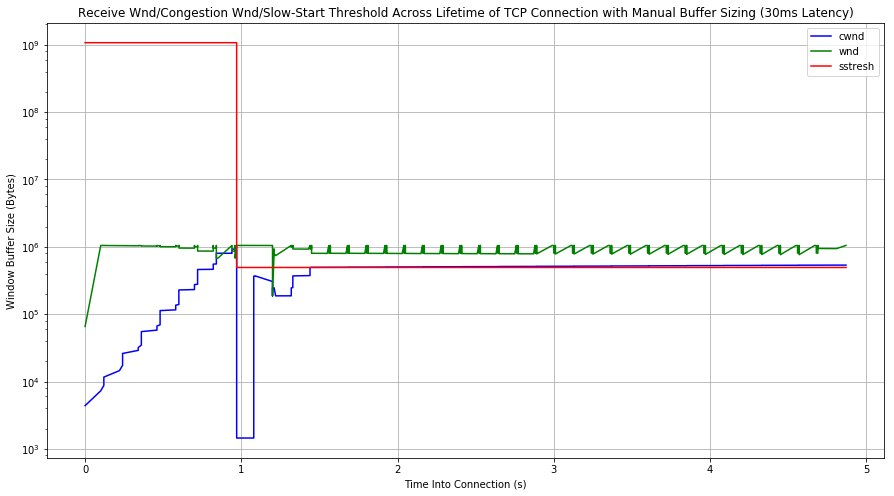

In [38]:
plot_windows(30)

## 40ms

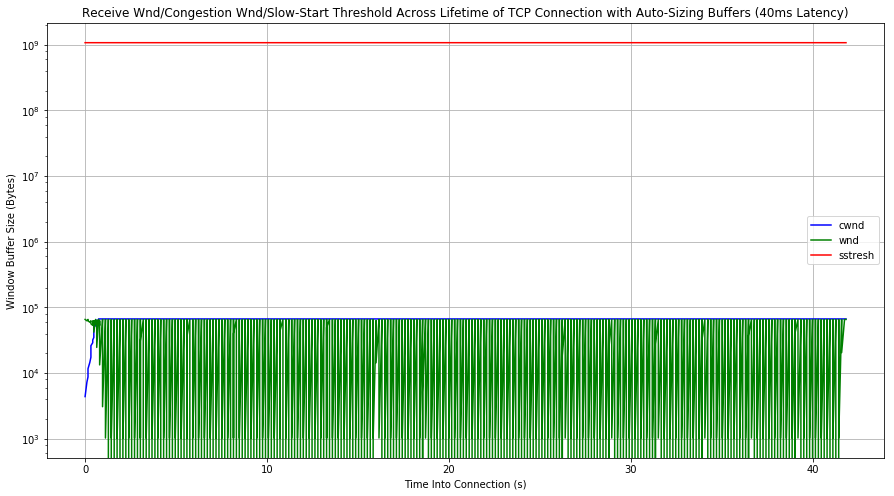

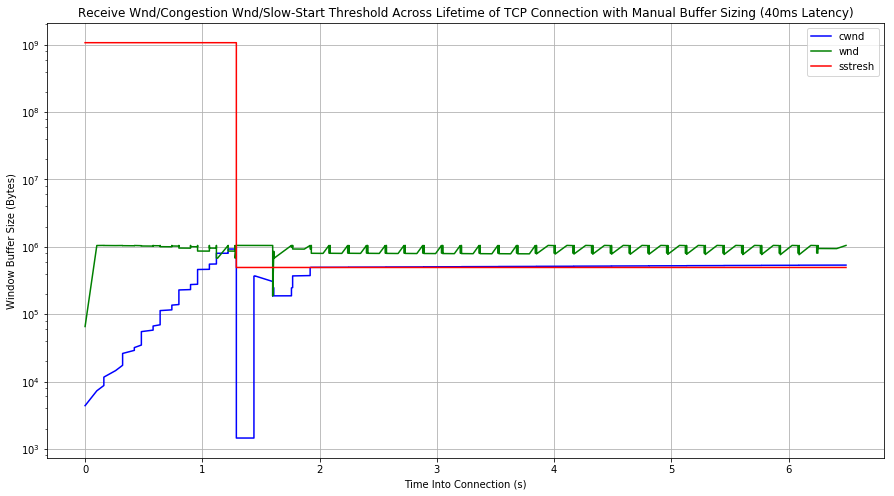

In [39]:
plot_windows(40)

# Seq-Time Diagrams

## 10ms RTT

In [17]:
ret_rcv = process_segments("combined_5_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_5_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
ret_rcv_s = process_segments("combined_5_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd_s = process_segments("combined_5_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

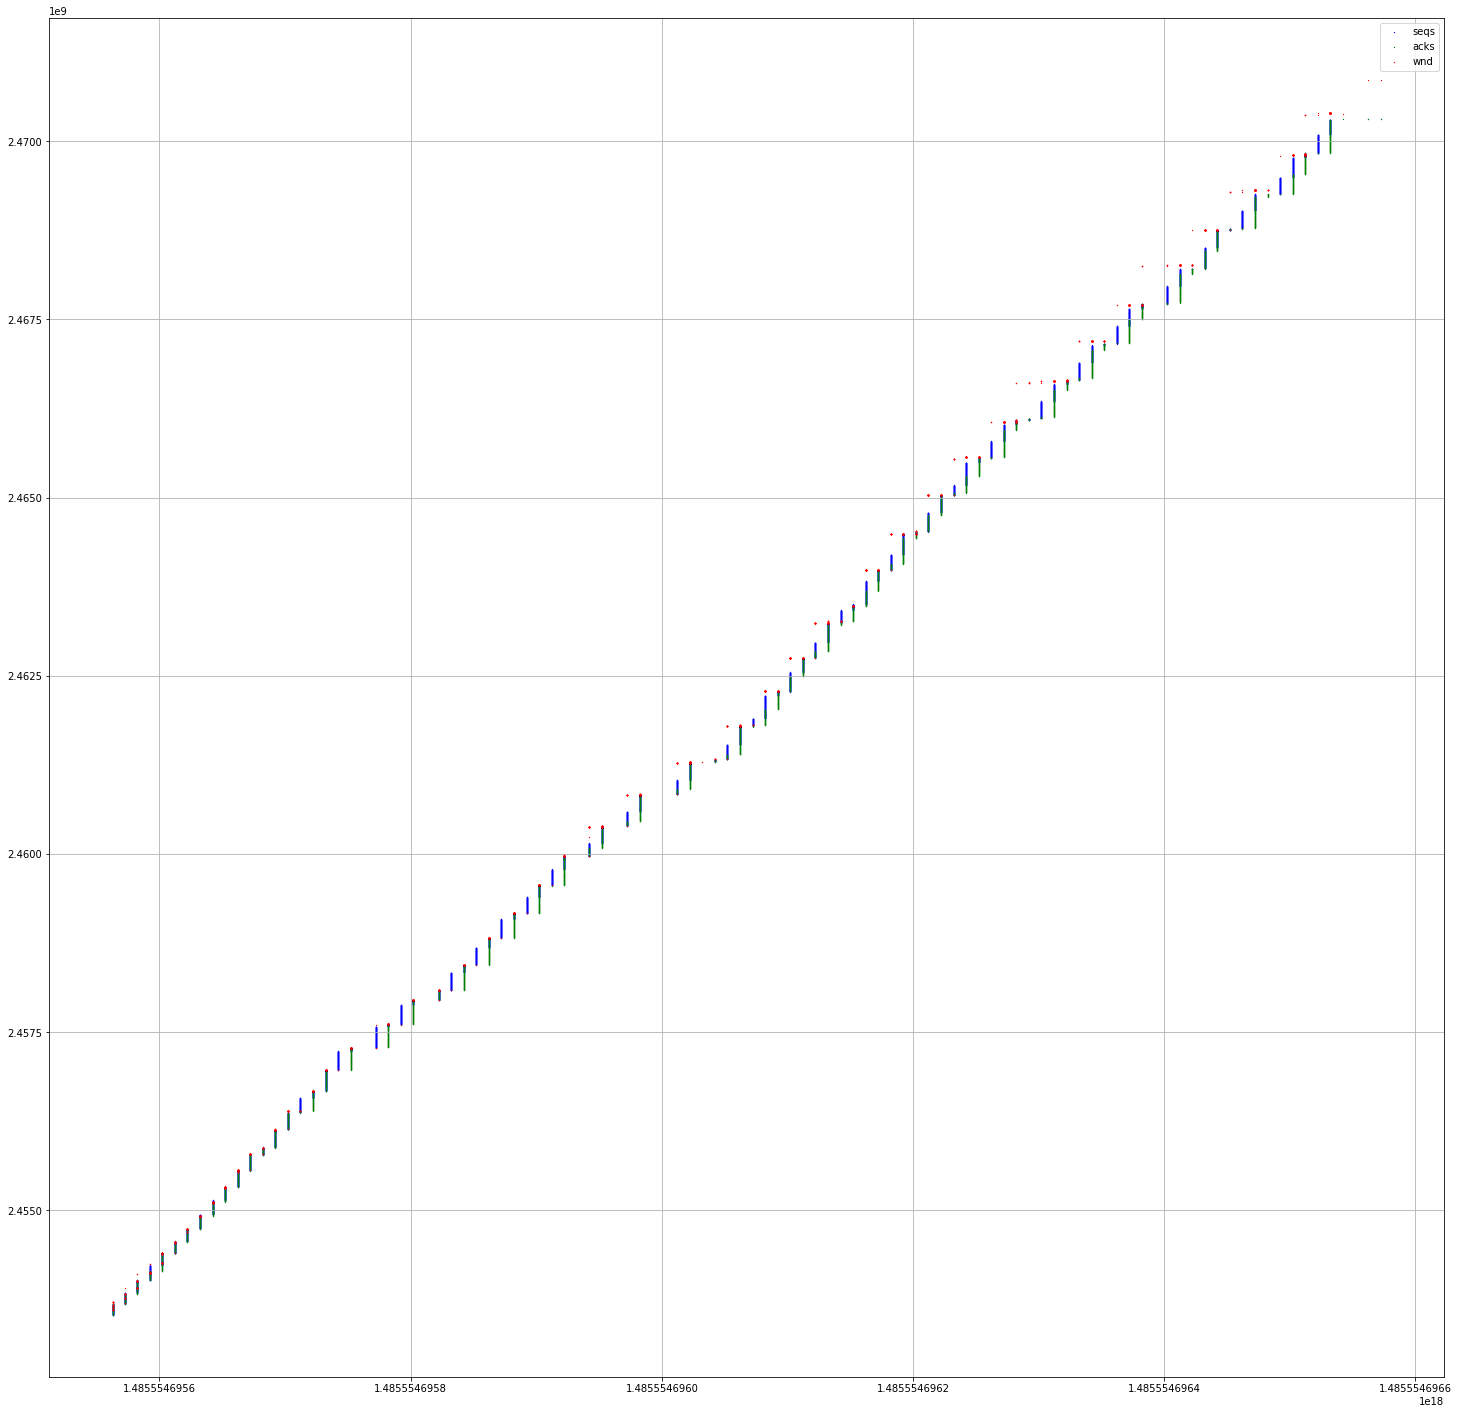

In [18]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs))
acks_range = slice(0,len(times_acks))
wnd_w_acks = [sum(x) for x in zip(acks, wnd)]
ax.scatter(times_seqs[seq_range], seqs[seq_range], s = 0.1, marker="x", label = "seqs")
ax.scatter(times_acks[acks_range], acks[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

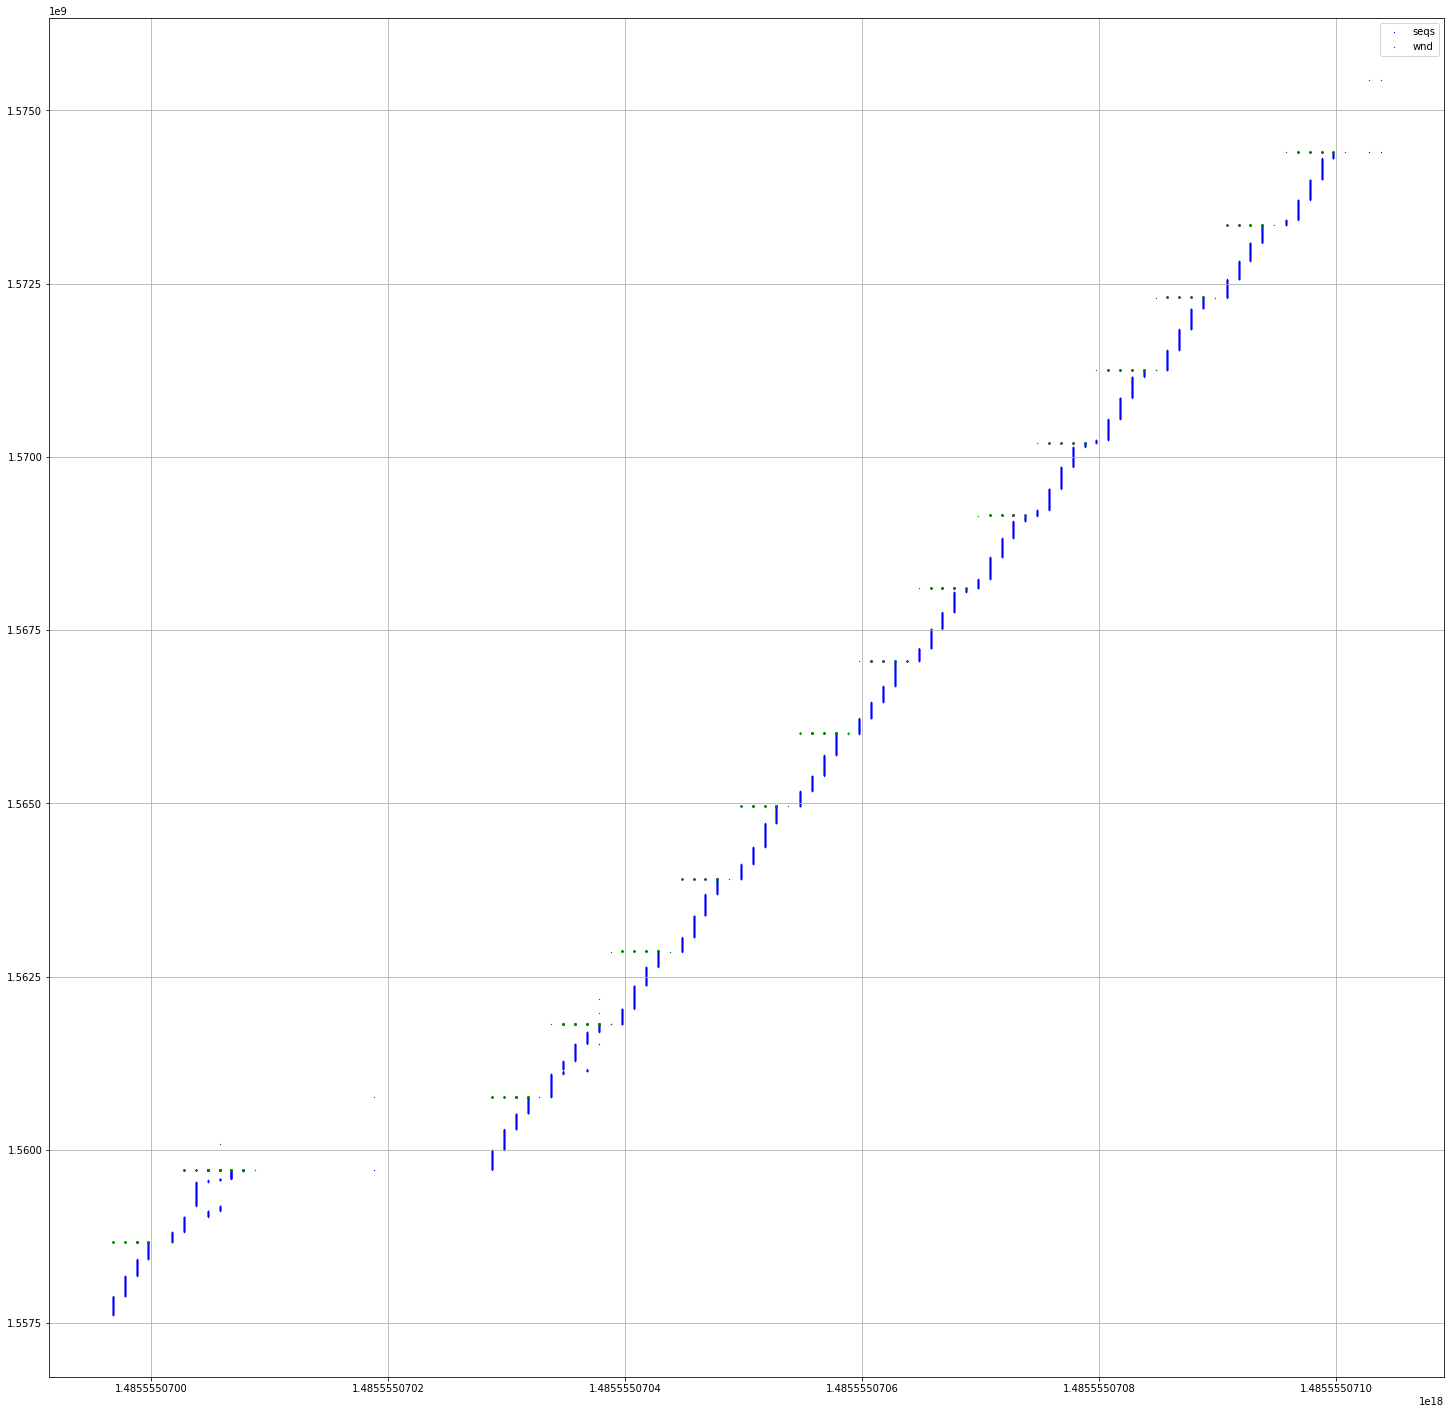

In [54]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs_s))
acks_range = slice(0,len(times_acks_s))
wnd_w_acks = [sum(x) for x in zip(acks_s, wnd_s)]
ax.scatter(times_seqs_s[seq_range], seqs_s[seq_range], s = 0.1, marker="x", label = "seqs")
#ax.scatter(times_acks_s[acks_range], acks_s[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks_s[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

## 20ms RTT

In [14]:
ret_rcv = process_segments("combined_10_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_10_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
ret_rcv_s = process_segments("combined_10_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd_s = process_segments("combined_10_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

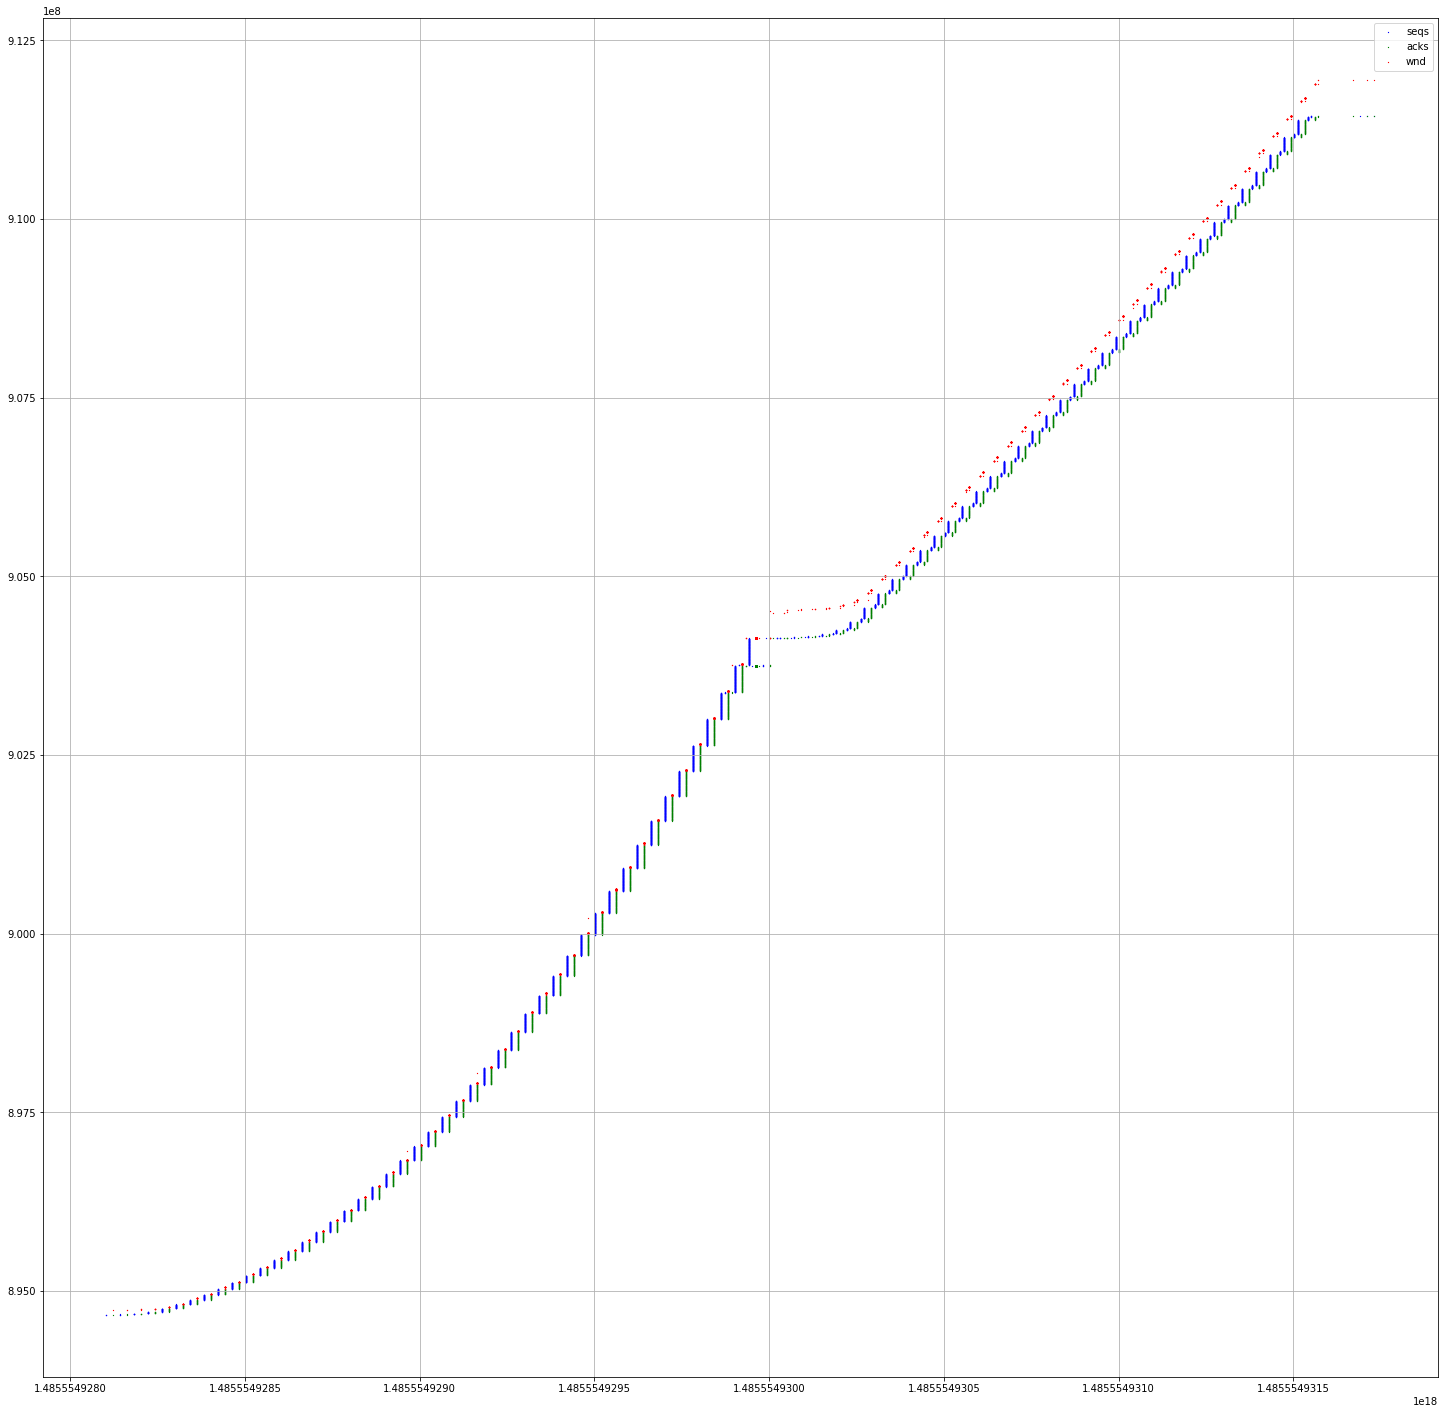

In [15]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs))
acks_range = slice(0,len(times_acks))
wnd_w_acks = [sum(x) for x in zip(acks, wnd)]
ax.scatter(times_seqs[seq_range], seqs[seq_range], s = 0.1, marker="x", label = "seqs")
ax.scatter(times_acks[acks_range], acks[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

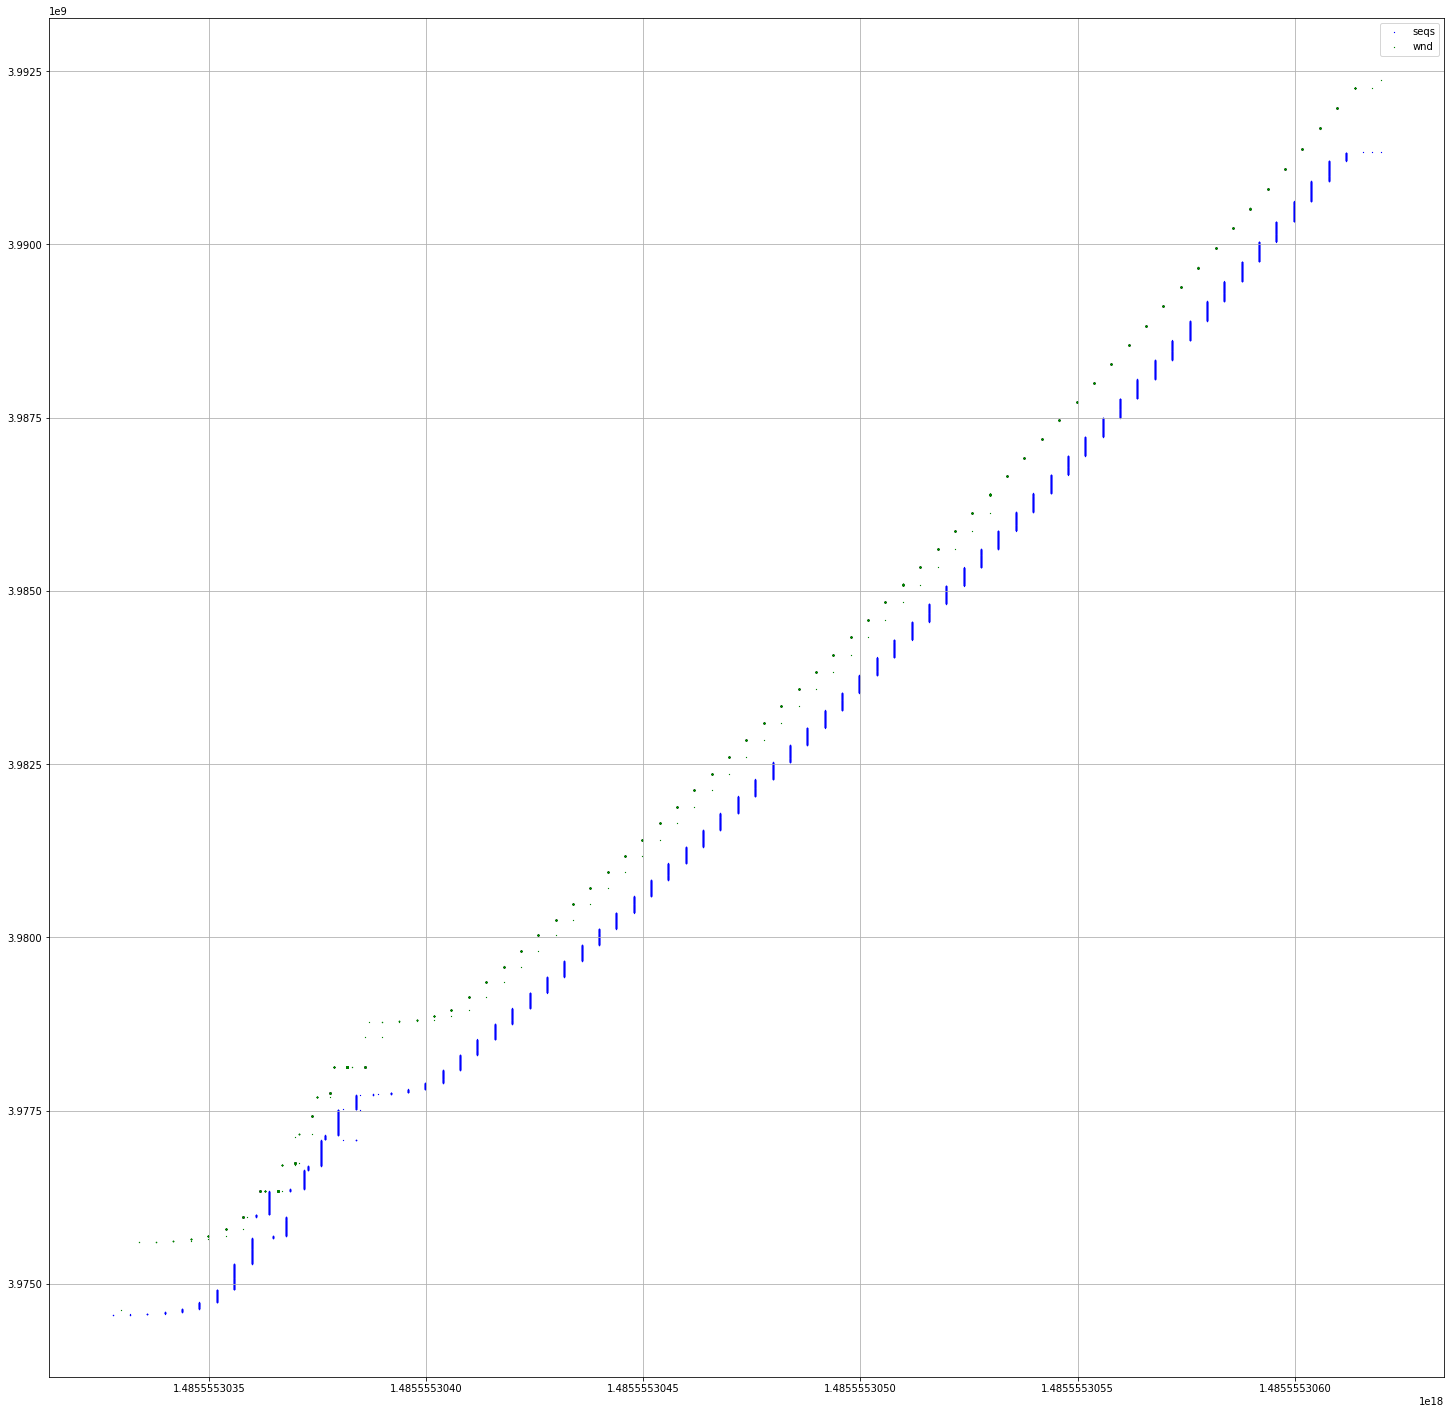

In [51]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
seq_range = slice(0,len(times_seqs_s))
acks_range = slice(0,len(times_acks_s))
wnd_w_acks = [sum(x) for x in zip(acks_s, wnd_s)]
ax.scatter(times_seqs_s[seq_range], seqs_s[seq_range], s = 0.1, marker="x", label = "seqs")
#ax.scatter(times_acks_s[acks_range], acks_s[acks_range], s = 0.1, marker="x", label = "acks")
ax.scatter(times_acks_s[acks_range], wnd_w_acks[acks_range], s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

## Experimental

In [28]:
ret_rcv = process_segments("combined_10_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"], single_ack = True)
ret_snd = process_segments("combined_10_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, times_single_acks, single_acks, acks, wnd = (ret_rcv["Time"],ret_rcv["SingleAckTime"], ret_rcv["SingleAcks"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])
ret_rcv_s = process_segments("combined_10_1_-s.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"], single_ack = True)
ret_snd_s = process_segments("combined_10_1_-s.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks_s, times_single_acks_s, single_acks_s, acks_s, wnd_s = (ret_rcv_s["Time"],ret_rcv_s["SingleAckTime"], ret_rcv_s["SingleAcks"], ret_rcv_s["Ack"], ret_rcv_s["wnd"])
times_seqs_s, seqs_s = (ret_snd_s["Time"], ret_snd_s["Seq"])

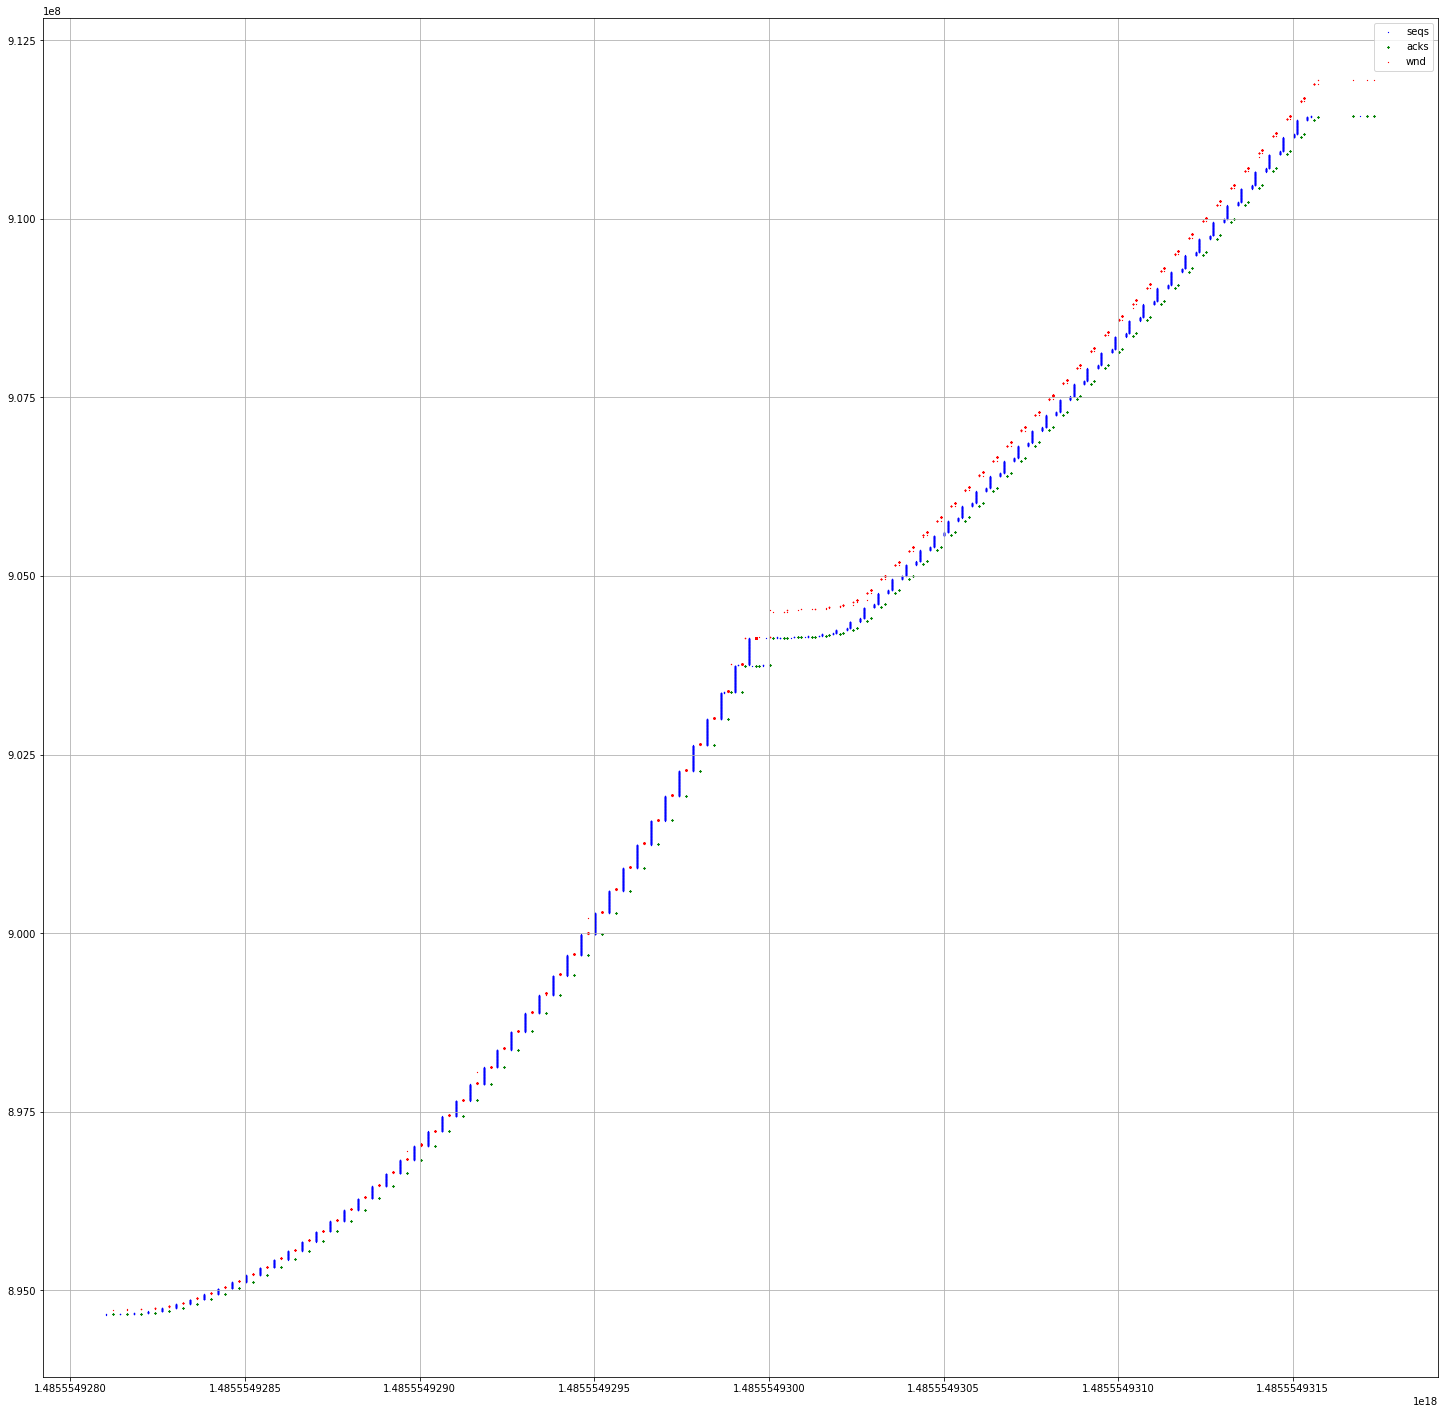

In [33]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
wnd_w_acks = [sum(x) for x in zip(acks, wnd)]
ax.scatter(times_seqs, seqs, s = 0.1, marker="x", label = "seqs")
ax.scatter(times_single_acks, single_acks, s = 2, marker="x", label = "acks")
ax.scatter(times_acks, wnd_w_acks, s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

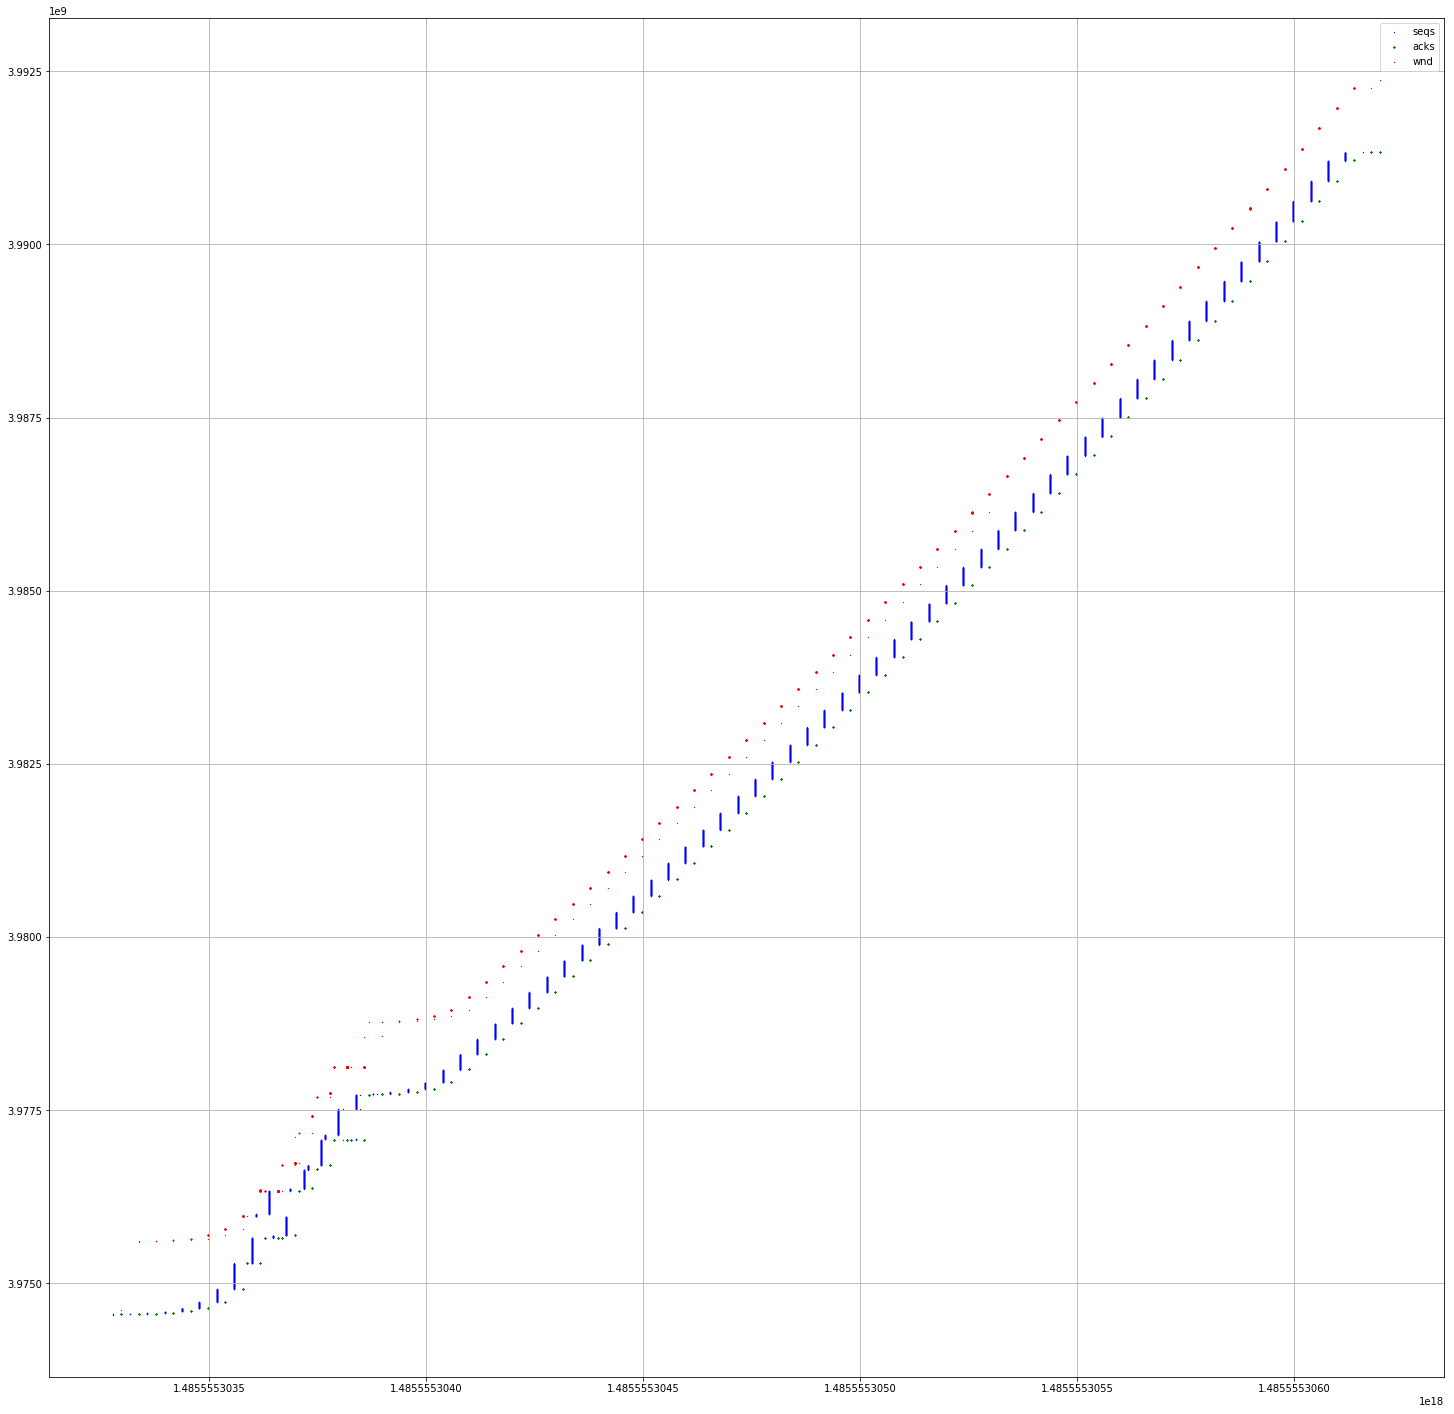

In [37]:
fig = plt.figure(figsize=(25, 25)) #figsize=(10, 10), dpi=80
plt.ticklabel_format(useOffset=False)
ax = plt.gca()
wnd_w_acks_s = [sum(x) for x in zip(acks_s, wnd_s)]
ax.scatter(times_seqs_s, seqs_s, s = 0.1, marker="x", label = "seqs")
ax.scatter(times_single_acks_s, single_acks_s, s = 2, marker="x", label = "acks")
ax.scatter(times_acks_s, wnd_w_acks_s, s = 0.1, marker="x", label = "wnd")
ax.legend(scatterpoints=1)
ax.grid(True)
plt.ticklabel_format(useOffset=False)

## Bytes-in-flight + Packet Length

In [26]:
ret_rcv = process_segments("combined_5_1.log", port = "dest", extra = ["cwnd", "wnd", "ssthresh"])
ret_snd = process_segments("combined_5_1.log", port = "source", extra = ["cwnd", "wnd", "ssthresh"])
times_acks, acks, wnd = (ret_rcv["Time"], ret_rcv["Ack"], ret_rcv["wnd"])
times_seqs, seqs = (ret_snd["Time"], ret_snd["Seq"])

In [27]:
bytes = []
cur_time = 0
for t, a, w in itertools.izip(times_acks, acks, [sum(x) for x in zip(acks, wnd)]):
    if cur_time != t:
        b = w - a
        cur_time = t
        bytes.append(b)

cur_time = times_seqs[0]
cur_s = []
sqs = []
for t, s in itertools.izip(times_seqs, seqs):
    if cur_time != t:
        cur_time = t
        sqs.append(cur_s[-1] - cur_s[0])
        cur_s = [s]
    else:
        cur_s.append(s)

In [28]:
for byte, segment in itertools.izip(bytes, sqs):
    print(byte, segment)

65536 156440
17408 154416
79872 174908
89088 207520
112640 166676
2048 168880
147456 173876
163840 199364
180224 197384
196608 186332
212992 227792
1024 220096
9216 104256
245760 248972
1024 237472
29696 202720
262144 95568
278528 292496
2048 263536
294912 44888
1024 296840
324608 27512
0 275120
327680 65160
2048 133216
1024 250504
360448 107152
1024 240368
360448 133216
0 263536
327680 76744
2048 230232
393216 159280
2048 225888
393216 182264
1024 182448
293888 241816
0 198376
361472 240368
2048 201272
366592 253400
1024 33304
34816 204168
0 263536
392192 101360
17408 320008
475136 53576
248832 270776
475136 201272
263168 214304
0 273672
401408 175208
47104 82536
215040 324352
507904 149144
290816 220096
1024 280912
420864 37648
61440 266432
507904 237472
281600 142428
1024 318560
505856 60816
274432 234576
507904 234576
497664 60816
117760 21720
515072 238920
501760 237472
504832 59368
125952 241816
540672 240368
514048 24616
120832 244712
540672 243264
535552 66608
202752 247608
523

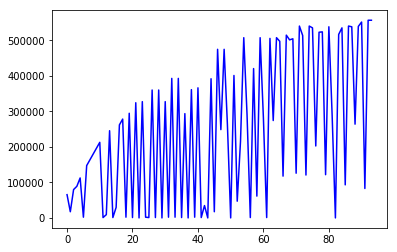

In [32]:
plt.plot(bytes)

## Probe Effect

	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
Running: ipc/ipc-static  -i tcp -b 1048576 -t 16777216 2thread
Discarded
Run: 1
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 2
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 3
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 4
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 5
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 6
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 7
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 8
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 9
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 10
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 11
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 12
net.inet.tcp.hostcache.purgenow: 0 -> 0
Aggregating
			1048576 bytes 16777216 bytes: 20861.02 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
		 ==> Running in DTrace mode
Running: ipc/ipc-static  -i tcp -b 1048576 -t 16777216 2thread
Discarded
Run: 1
net.inet.tcp.hostcache.purgenow: 0 -> 0
Run: 

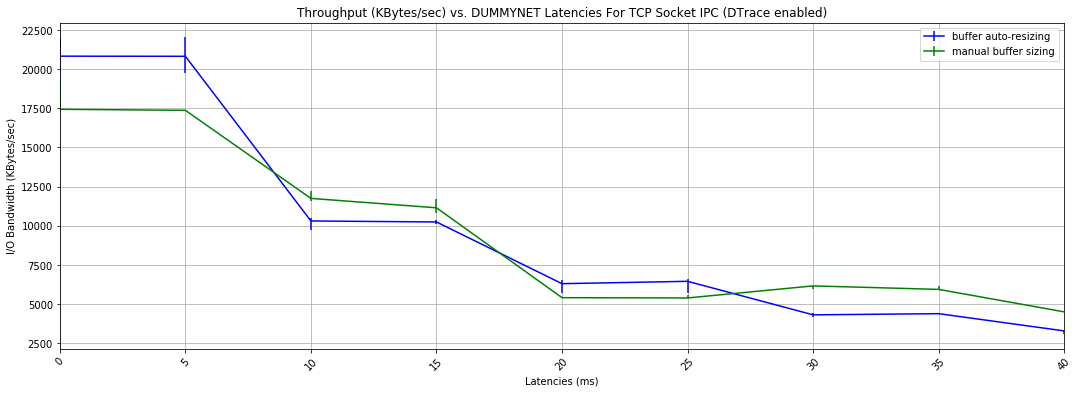

In [14]:
MODE="2thread"
IPC="tcp"
RUNS=12
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(2, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]
BUF_SIZE=[1048576]
LATENCIES=range(0, 45, 5) # 0-40ms

ret = []
FLAGS=""
for lat in LATENCIES:
    # Run benchmark with DTrace
    !ipfw pipe config 1 delay {str(lat)}
    !ipfw pipe config 2 delay {str(lat)}
    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True,
                            dtrace_info = {'agg_fn':dummy_agg, 'script':D_rcv_tcp_in})[0])
pd.to_pickle(ret, "pkls/latency_vs_bandwidth_purge_probe_effect_segment.pkl")

#ret = pd.read_pickle("pkls/latency_vs_bandwidth_purge_probe_effect_segment.pkl")
p = graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
         xlabel='Latencies (ms)', ylabel='I/O Bandwidth (KBytes/sec)',
          label="buffer auto-resizing", title = "Throughput (KBytes/sec) vs. DUMMYNET Latencies For TCP Socket IPC (DTrace enabled)")

ret = []
FLAGS="-s"
for lat in LATENCIES:
    # Run benchmark with DTrace
    !ipfw pipe config 1 delay {str(lat)}
    !ipfw pipe config 2 delay {str(lat)}
    ret.append(benchmark(FLAGS, 12, EXE, MODE, IPC, BUF_SIZE, TOT_SIZES, purge_cache = True,
                           dtrace_info = {'agg_fn':dummy_agg, 'script':D_rcv_tcp_in})[0])
pd.to_pickle(ret, "pkls/latency_vs_bandwidth_match_purge_probe_effect_segment.pkl")

saveas = "latency_vs_bw_all"
#ret = pd.read_pickle("pkls/latency_vs_bandwidth_match_purge_probe_effect_segment.pkl")
graph(LATENCIES, flatten([item['speeds'] for item in ret]), RUNS,
      axis = p, label="manual buffer sizing", save = True, save_name = saveas)

## DUMMYNET Probe Effect

In [12]:
MODE="2thread"
IPC="tcp"
RUNS=12
EXE = "ipc/ipc-static"
BUFFER_SIZES = [512 * 2 ** exp for exp in range(8, 16)]
TOT_SIZES=[BUFFER_SIZES[-1]]

FLAGS=""
ret_0 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)

FLAGS="-s"
ret_1 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)

!ipfw pipe config 1 delay 0
!ipfw pipe config 2 delay 0
!ipfw add 1 pipe 1 tcp from any 10141 to any via lo0
!ipfw add 2 pipe 2 tcp from any to any 1011 via lo0

FLAGS=""
ret_2 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)

FLAGS="-s"
ret_3 = benchmark(FLAGS, RUNS, EXE, MODE, IPC, BUFFER_SIZES, TOT_SIZES)

out = { 'plain_auto':ret_0, 'plain_manual':ret_1, 'dummy_auto':ret_2, 'dummy_manual':ret_3 }
pd.to_pickle(out, "pkls/dummynet_probe_effect.pkl")

	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
			131072 bytes 16777216 bytes: 35504.63 KBytes/sec
			262144 bytes 16777216 bytes: 43744.41 KBytes/sec
			524288 bytes 16777216 bytes: 43679.19 KBytes/sec
			1048576 bytes 16777216 bytes: 43341.83 KBytes/sec
			2097152 bytes 16777216 bytes: 43098.34 KBytes/sec
			4194304 bytes 16777216 bytes: 42291.65 KBytes/sec
			8388608 bytes 16777216 bytes: 40135.33 KBytes/sec
			16777216 bytes 16777216 bytes: 36530.24 KBytes/sec
	 ==> Running ipc/ipc-static
		 ==> tcp across 2thread
			131072 bytes 16777216 bytes: 59489.31 KBytes/sec
			262144 bytes 16777216 bytes: 60265.26 KBytes/sec
			524288 bytes 16777216 bytes: 64145.94 KBytes/sec
			1048576 bytes 16777216 bytes: 64989.10 KBytes/sec
			2097152 bytes 16777216 bytes: 64353.78 KBytes/sec
			4194304 bytes 16777216 bytes: 60890.84 KBytes/sec
			8388608 bytes 16777216 bytes: 56048.79 KBytes/sec
			16777216 bytes 16777216 bytes: 47388.92 KBytes/sec
00001 pipe 1 tcp from any 10141 to any via lo0

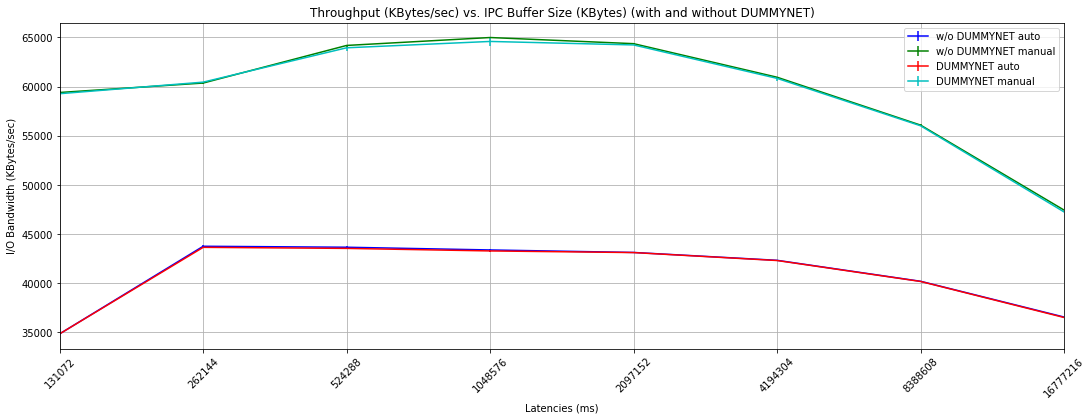

In [13]:
out = pd.read_pickle("pkls/dummynet_probe_effect.pkl")
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in out['plain_auto']]), RUNS,
         xlabel='Latencies (ms)', ylabel='I/O Bandwidth (KBytes/sec)',
          label="w/o DUMMYNET auto", title = "Throughput (KBytes/sec) vs. IPC Buffer Size (KBytes) (with and without DUMMYNET)")

p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in out['plain_manual']]), RUNS,label="w/o DUMMYNET manual", axis = p)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in out['dummy_auto']]), RUNS,label="DUMMYNET auto", axis = p)
p = graph(BUFFER_SIZES, flatten([item['speeds'] for item in out['dummy_manual']]), RUNS,label="DUMMYNET manual", axis = p)

p.set_xscale('log', basex=2)
p.set_xticklabels([""] + BUFFER_SIZES)

# Statistical Analysis

* do null hypothesis test on mean for thread models for pipe vs local; do null hypothesis test on local with and without matching buffers
* median test using scipy->run 10 and 20 runs of benchmark for hypothesis tests->plot p-value as buffer size increases
* test for statistical difference in matching vs. non-matching socketpairs
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html
* https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/meditest.htm
* https://en.wikipedia.org/wiki/Median_test
* https://www.cl.cam.ac.uk/teaching/1819/L41/notes/2018-2019-l41-lab-1-io-notes.pdf

# Notes

* https://www.cl.cam.ac.uk/teaching/1819/L41/2018-2019-l41-lecturelet4-lab-tcp-p1-handout.pdf
* RFC 793: https://tools.ietf.org/html/rfc793
* RFC 893: https://tools.ietf.org/html/rfc893
* dtrace -n 'fbt::tcp_do_segment:entry/ntohs(args[3]->t_inpcb->inp_inc.inc_ie.ie_lport) == 10141 || ntohs(args[3]->t_inpcb->inp_inc.inc_ie.ie_fport) == 10141/ { trace((unsigned int)args[1]->th_seq); trace((unsigned int)args[1]->th_ack); trace(tcp_state_string[args[3]->t_state]);}'
  * state-syn-sent
  * state-syn-received
  * state-established
  * state-fin-wait-1
  * state-fin-wait-2
  * state-last-ack
* For state transitions:
  * dtrace -n 'fbt::tcp_state_change:entry/ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport) == 10141 || ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport) == 10141/ {   trace(ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_lport));  trace(ntohs(args[0]->t_inpcb->inp_inc.inc_ie.ie_fport));  trace(tcp_state_string[args[0]->t_state]);  trace(tcp_state_string[args[1]]); }'
* Sequence numbers have a gap of 44bytes between each other

## IPFW and DUMMYNET
* Should be:
  * 2thread
  * ipc-static
  * without -s
  * tcp mode
* TODO: add below snippets to benchmark shell script

* Lab:
  * Plot:
    * TCP state-transition diagram for two directions of a single TCP connection
    * nodes: states
    * edges: transitions
    * indicate client vs server for diverging transitions
    * for each indicate TCP header flags of received packet or syscall (or other event e.g. timer) that triggers transition
  * Compare graphs to TCP stat diagram in RFC 793
  * Use DUMMYNET to explore effects of simulated latency at 5ms intervals between 0ms and 40ms. Record changes to state-machine transisionts as latency changes
  * For above use -B -q flags (whole-program analysis)